In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [1]:
!pip install ultralytics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 661.2/661.2 kB 3.6 MB/s eta 0:00:00


In [34]:
!pip install mediapipe

In [36]:
import cv2
import mediapipe as mp
import numpy as np
import os
import random
import gc
import time
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt

from IPython.display import Image, clear_output
from torch.cuda import memory_allocated, empty_cache
from torch.optim import Adam
from torch.utils.data import random_split
from torch.utils.data import Dataset, DataLoader
from glob import glob
from tqdm import tqdm
from google.colab.patches import cv2_imshow
from ultralytics import YOLO
import torch
import torchvision
import pandas

%matplotlib inline

In [5]:
yolo_model = YOLO('yolov8s.pt')

# 디바이스 설정
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
yolo_model = yolo_model.to(device)

100%|██████████| 21.5M/21.5M [00:00<00:00, 114MB/s] 


In [11]:
BATCH_SIZE = 6
EPOCH = 100
NUM_LAYERS = 1      # LSTM model: num_layers
start_dot = 11      # mp.solutions.pose 시작 포인트 (0: 얼굴부터 발목까지, 11: 어깨부터 발목까지)
n_CONFIDENCE = 0.3    # MediaPipe Min Detectin confidence check
y_CONFIDENCE = 0.3

mp_pose = mp.solutions.pose
attention_dot = [n for n in range(start_dot, 29)]

# 라인 그리기
if start_dot == 11:
# 몸 부분만 머리는 신경 안써도 될듯?
    draw_line = [[11, 13], [13, 15], [15, 21], [15, 19], [15, 17], [17, 19], \
                [12, 14], [14, 16], [16, 22], [16, 20], [16, 18], [18, 20], \
                [23, 25], [25, 27], [24, 26], [26, 28], [11, 12], [11, 23], \
                [23, 24], [12, 24]]
    print('Pose : Only Body')

else:
# 몸 전체
    draw_line = [[11, 13], [13, 15], [15, 21], [15, 19], [15, 17], [17, 19], \
                [12, 14], [14, 16], [16, 22], [16, 20], [16, 18], [18, 20], \
                [23, 25], [25, 27], [24, 26], [26, 28], [11, 12], [11, 23], \
                [23, 24], [12, 24], [9, 10], [0, 5], [0, 2], [5, 8], [2, 7]]
    print('Pose : Face + Body')

Pose : Only Body


In [35]:
net.eval()

length = 30 # frame 상태를 표시할 길이
out_img_list = []
dataset = []
status = 'None'
pose = mp_pose.Pose(static_image_mode=True, model_complexity=1, enable_segmentation=False, min_detection_confidence=n_CONFIDENCE)
print('시퀀스 데이터 분석 중...')

xy_list_list = []
for img in tqdm(img_list):
    res = yolo_model(img)
    res_refine = res.pandas().xyxy[0].values

    nms_human = len(res_refine)
    if nms_human > 0:
        for bbox in res_refine:
            xx1, yy1, xx2, yy2 = int(bbox[0])-10, int(bbox[1]), int(bbox[2])+10, int(bbox[3])
            if xx1 < 0:
                xx1 = 0
            elif xx2 > 639:
                xx2 = 639
            if yy1 < 0:
                yy1 = 0
            elif yy2 > 639:
                yy2 = 639

            start_point = (xx1, yy1)
            end_point = (xx2, yy2)
            if bbox[4] > y_CONFIDENCE:
                img = cv2.rectangle(img, start_point, end_point, (0, 0, 255), 2)

                c_img = img[yy1:yy2, xx1:xx2]
                results = pose.process(cv2.cvtColor(c_img, cv2.COLOR_BGR2RGB))
                if not results.pose_landmarks: continue
                xy_list = []
                idx = 0
                draw_line_dic = {}
                for x_and_y in results.pose_landmarks.landmark:
                    if idx in attention_dot:
                        xy_list.append(x_and_y.x)
                        xy_list.append(x_and_y.y)
                        x, y = int(x_and_y.x*(xx2-xx1)), int(x_and_y.y*(yy2-yy1))
                        draw_line_dic[idx] = [x, y]
                    idx += 1

                xy_list_list.append(xy_list)
                # 라인 그리기 (지워도 됨)
                for line in draw_line:
                    x1, y1 = draw_line_dic[line[0]][0], draw_line_dic[line[0]][1]
                    x2, y2 = draw_line_dic[line[1]][0], draw_line_dic[line[1]][1]
                    c_img = cv2.line(c_img, (x1, y1), (x2, y2), (0, 255, 0), 3)

                if len(xy_list_list) == length:
                    dataset = []
                    dataset.append({'key' : 0, 'value' : xy_list_list})
                    dataset = MyDataset(dataset)
                    dataset = DataLoader(dataset)
                    xy_list_list = []

                    for data, label in dataset:
                        data = data.to(device)
                        with torch.no_grad():
                            result = net(data)
                            _, out = torch.max(result, 1)
                            if out.item() == 0: status = 'Normal'
                            else: status = 'Abnormal'
    if status == 'Normal':
        text_color = (0, 255, 0)  # 녹색
        cv2.putText(img, status, (0, 50), cv2.FONT_HERSHEY_COMPLEX, 1.5, text_color, 2)
    elif status == 'Abnormal':
        text_color = (0, 0, 255)  # 빨간색
        cv2.putText(img, status, (0, 50), cv2.FONT_HERSHEY_COMPLEX, 1.5, text_color, 2)

        # 추가적인 경고 메시지 표시
        cv2.putText(img, 'WARNING: Abnormal Activity Detected!', (50, img.shape[0] // 2), cv2.FONT_HERSHEY_COMPLEX, 1, text_color, 2)

        # 화면 깜빡임 효과 추가 (예: 이미지의 경계에 빨간색 사각형 그리기)
        cv2.rectangle(img, (0, 0), (img.shape[1], img.shape[0]), text_color, 10)

    out_img_list.append(img)

    cv2.putText(img, status, (0, 50), cv2.FONT_HERSHEY_COMPLEX, 1.5, (0, 0, 255), 2)
    out_img_list.append(img)

시퀀스 데이터 분석 중...


  0%|          | 0/180 [00:00<?, ?it/s]


0: 640x640 1 suitcase, 4 chairs, 1 potted plant, 1 tv, 896.1ms
Speed: 4.7ms preprocess, 896.1ms inference, 2.9ms postprocess per image at shape (1, 3, 640, 640)


  0%|          | 0/180 [00:00<?, ?it/s]


AttributeError: ignored

In [13]:
video_path = '/content/drive/MyDrive/CCTV/Data'
raw_data = []

for fold in os.listdir(video_path):
    label = 0 if fold == 'normal' else 1

    for video_name in os.listdir(os.path.join(video_path, fold)):
        skel_data_n, skel_data_f = get_skeleton(os.path.join(video_path, fold, video_name), attention_dot, draw_line)
        if skel_data_n is not None and len(skel_data_n) > 0:
            seq_list_n = skel_data_n[:30]
            seq_list_f = skel_data_f[:30]
            raw_data.append({'key': label, 'value': seq_list_n})
            raw_data.append({'key': label, 'value': seq_list_f})

# 데이터셋을 무작위로
random.shuffle(raw_data)


0: 640x640 1 person, 1 handbag, 9 bottles, 1 cup, 1173.1ms
Speed: 11.9ms preprocess, 1173.1ms inference, 2.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8 bottles, 1 cup, 1 tv, 849.6ms
Speed: 7.2ms preprocess, 849.6ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7 bottles, 1 cup, 1 tv, 552.1ms
Speed: 3.0ms preprocess, 552.1ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 9 bottles, 1 cup, 1 tv, 543.7ms
Speed: 3.8ms preprocess, 543.7ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 9 bottles, 1 cup, 1 tv, 541.3ms
Speed: 2.9ms preprocess, 541.3ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8 bottles, 1 cup, 1 tv, 558.2ms
Speed: 2.9ms preprocess, 558.2ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7 bottles, 1 cup, 1 tv, 848.8ms
Speed: 2.9ms preprocess, 8

In [14]:
# 길이
nd = 0
ad = 0
for i in range(len(raw_data)):
    if raw_data[i]['key'] == 0:
        nd += 1
    else:
        ad += 1
print('normal data:', nd, '| abnormal data:', ad)

normal data: 40 | abnormal data: 40


In [15]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

# 모델 구조

In [16]:
class MyDataset(Dataset):
    def __init__(self, seq_list):
        self.X = []
        self.y = []
        for dic in seq_list :
            self.y.append(dic['key'])
            self.X.append(dic['value'])

    def __getitem__(self, index):
        data = self.X[index]
        label = self.y[index]
        return torch.Tensor(np.array(data)), torch.tensor(np.array(int(label)))

    def __len__(self):
        return len(self.X)

In [17]:
split_ratio = [0.8, 0.1, 0.1]
train_len = int(len(raw_data) * split_ratio[0])
val_len = int(len(raw_data) * split_ratio[1])
test_len = len(raw_data) - train_len - val_len

print('{}, {}, {}'.format(train_len, val_len, test_len))

64, 8, 8


In [24]:
train_dataset = MyDataset(raw_data)
train_data, valid_data, test_data = random_split(train_dataset, [train_len, val_len, test_len])

train_loader = DataLoader(train_data, batch_size=BATCH_SIZE)
val_loader = DataLoader(valid_data, batch_size=BATCH_SIZE)
test_loader = DataLoader(test_data, batch_size=BATCH_SIZE)

In [25]:
# LSTM
class skeleton_LSTM(nn.Module):
    def __init__(self):
        super(skeleton_LSTM, self).__init__()
        self.lstm1 = nn.LSTM(input_size=len(attention_dot) * 2, hidden_size=128, num_layers=NUM_LAYERS, batch_first=True)
        self.lstm2 = nn.LSTM(input_size=128, hidden_size=256, num_layers=NUM_LAYERS, batch_first=True)
        self.lstm3 = nn.LSTM(input_size=256, hidden_size=512, num_layers=NUM_LAYERS, batch_first=True)
        self.dropout1 = nn.Dropout(0.1)
        self.lstm4 = nn.LSTM(input_size=512, hidden_size=256, num_layers=NUM_LAYERS, batch_first=True)
        self.lstm5 = nn.LSTM(input_size=256, hidden_size=128, num_layers=NUM_LAYERS, batch_first=True)
        self.lstm6 = nn.LSTM(input_size=128, hidden_size=64, num_layers=NUM_LAYERS, batch_first=True)
        self.dropout2 = nn.Dropout(0.1)
        self.lstm7 = nn.LSTM(input_size=64, hidden_size=32, num_layers=NUM_LAYERS, batch_first=True)
        self.fc = nn.Linear(32,2)

    def forward(self, x) :
        x, _ = self.lstm1(x)
        x, _ = self.lstm2(x)
        x, _ = self.lstm3(x)
        x = self.dropout1(x)
        x, _ = self.lstm4(x)
        x, _ = self.lstm5(x)
        x, _ = self.lstm6(x)
        x = self.dropout2(x)
        x, _ = self.lstm7(x)
        x = self.fc(x[:,-1,:]) # x[배치 크기, 시퀀스 길이, 은닉 상태 크기], [:, -1, :] -> 마지막 시간 단계만 선택

        return x

In [26]:
# 모델 초기화

def init_model():
    global net, loss_fn, optim
    plt.rc('font', size = 10)
    net = skeleton_LSTM().to(device)
    loss_fn = nn.CrossEntropyLoss()
    optim = Adam(net.parameters(), lr=0.0001)

# epoch 카운터 초기화
def init_epoch():
    global epoch_cnt
    epoch_cnt = 0

# 모든 Log를 초기화
def init_log():
    global log_stack, iter_log, tloss_log, tacc_log, vloss_log, vacc_log, time_log
    plt.rc('font', size = 10)
    iter_log, tloss_log, tacc_log, vloss_log, vacc_log = [], [], [], [], []
    time_log, log_stack = [], []

In [27]:
def record_train_log(_tloss, _tacc, _time):
    # Train Log 기록
    time_log.append(_time)
    tloss_log.append(_tloss)
    tacc_log.append(_tacc)
    iter_log.append(epoch_cnt)

def record_valid_log(_vloss, _vacc):
    # Validation Log 기록
    vloss_log.append(_vloss)
    vacc_log.append(_vacc)

def last(log_list):
    # last 안의 마지막 숫자를 반환(print_log 함수에서 사용)
    if len(log_list) > 0:
        return log_list[len(log_list) - 1]
    else:
        return -1

def print_log():
    # 학습 추이 출력 : 소숫점 3자리까지
    train_loss = round(float(last(tloss_log)), 3)
    train_acc = round(float(last(tacc_log)), 3)
    val_loss = round(float(last(vloss_log)), 3)
    val_acc = round(float(last(vacc_log)), 3)
    time_spent = round(float(last(time_log)), 3)

    log_str = 'Epoch: {:3} | T_Loss {:5} | T_Acc {:5} | V_Loss {:5} | V_Acc {:5} | {:5}'.format(last(iter_log), train_loss, train_acc, val_loss, val_acc, time_spent)

    log_stack.append(log_str)

    # 학습 추이 그래프 출력
    hist_fig, loss_axis = plt.subplots(figsize=(10, 3), dpi=99)
    hist_fig.patch.set_facecolor('white')

    # Loss Line 구성
    loss_t_line = plt.plot(iter_log, tloss_log, label='Train_Loss', color='red', marker='o')
    loss_v_line = plt.plot(iter_log, vloss_log, label='Valid_Loss', color='blue', marker='s')
    loss_axis.set_xlabel('epoch')
    loss_axis.set_ylabel('loss')

    # Acc, Line 구성
    acc_axis = loss_axis.twinx()
    acc_t_line = acc_axis.plot(iter_log, tacc_log, label='Train_Acc', color='red', marker='+')
    acc_v_line = acc_axis.plot(iter_log, vacc_log, label='Valid_Acc', color='blue', marker='x')
    acc_axis.set_ylabel('accuracy')

    # 그래프 출력
    hist_lines = loss_t_line + loss_v_line + acc_t_line + acc_v_line
    loss_axis.legend(hist_lines, [l.get_label() for l in hist_lines])
    loss_axis.grid()
    plt.title('Learning history until epoch {}'.format(last(iter_log)))
    plt.draw()

    # 텍스트 로그 출력
    clear_output(wait=True)
    plt.show()
    for idx in reversed(range(len(log_stack))):
        print(log_stack[idx])

In [28]:
def clear_memory():
    if device != 'cpu':
        empty_cache()
    gc.collect()

# 학습 알고리즘
def epoch(data_loader, mode = 'train'):
    global epoch_cnt

    # 사용되는 변수 초기화
    iter_loss, iter_acc, last_grad_performed = [], [], False

    # 1 iteration 학습 알고리즘(for문을 나오면 1 epoch 완료)
    for _data, _label in data_loader:
        data, label = _data.to(device), _label.type(torch.LongTensor).to(device)

        # 1. Feed-forward
        if mode == 'train':
            net.train()
        else:
            # 학습때만 쓰이는 Dropout, Batch Mormalization을 미사용
            net.eval()

        result = net(data) # 1 Batch에 대한 결과가 모든 Class에 대한 확률값으로
        _, out = torch.max(result, 1) # result에서 최대 확률값을 기준으로 예측 class 도출( _ : 값 부분은 필요 없음, out : index 중 가장 큰 하나의 데이터)

        # 2. Loss 계산
        loss = loss_fn(result, label) # GT 와 Label 비교하여 Loss 산정
        iter_loss.append(loss.item()) # 학습 추이를 위하여 Loss를 기록

        # 3. 역전파 학습 후 Gradient Descent
        if mode == 'train':
            optim.zero_grad() # 미분을 통해 얻은 기울기를 초기화 for 다음 epoch
            loss.backward() # 역전파 학습
            optim.step() # Gradient Descent 수행
            last_grad_performed = True # for문을 나가면 epoch 카운터 += 1

        # 4. 정확도 계산
        acc_partial = (out == label).float().sum() # GT == Label 인 개수
        acc_partial = acc_partial / len(label) # ( TP / (TP + TM)) 해서 정확도 산출
        iter_acc.append(acc_partial.item()) # 학습 추이를 위하여 Acc. 기록

    # 역전파 학습 후 Epoch 카운터 += 1
    if last_grad_performed:
        epoch_cnt += 1

    clear_memory()

    # loss와 acc의 평균값 for 학습추이 그래프, 모든 GT와 Label 값 for 컨퓨전 매트릭스
    return np.average(iter_loss), np.average(iter_acc)

def epoch_not_finished():
    # 에폭이 끝남을 알림
    return epoch_cnt < maximum_epoch

# 모델 학습

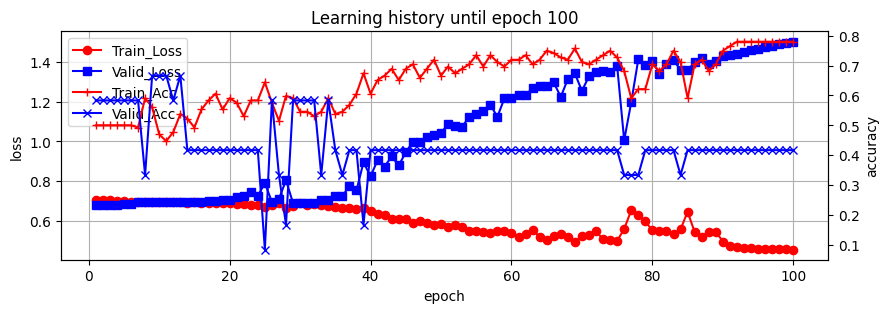

Epoch: 100 | T_Loss 0.453 | T_Acc  0.78 | V_Loss 1.503 | V_Acc 0.417 | 1.485
Epoch:  99 | T_Loss 0.454 | T_Acc  0.78 | V_Loss 1.496 | V_Acc 0.417 | 2.183
Epoch:  98 | T_Loss 0.454 | T_Acc  0.78 | V_Loss 1.489 | V_Acc 0.417 | 2.956
Epoch:  97 | T_Loss 0.456 | T_Acc  0.78 | V_Loss 1.482 | V_Acc 0.417 | 2.048
Epoch:  96 | T_Loss 0.456 | T_Acc  0.78 | V_Loss 1.475 | V_Acc 0.417 | 1.769
Epoch:  95 | T_Loss 0.458 | T_Acc  0.78 | V_Loss 1.467 | V_Acc 0.417 |  1.49
Epoch:  94 | T_Loss  0.46 | T_Acc  0.78 | V_Loss 1.459 | V_Acc 0.417 | 1.502
Epoch:  93 | T_Loss 0.462 | T_Acc  0.78 | V_Loss 1.451 | V_Acc 0.417 | 1.455
Epoch:  92 | T_Loss 0.466 | T_Acc  0.78 | V_Loss 1.443 | V_Acc 0.417 |  1.47
Epoch:  91 | T_Loss 0.471 | T_Acc 0.765 | V_Loss 1.435 | V_Acc 0.417 | 2.041
Epoch:  90 | T_Loss 0.494 | T_Acc  0.75 | V_Loss 1.429 | V_Acc 0.417 | 3.464
Epoch:  89 | T_Loss 0.544 | T_Acc 0.705 | V_Loss 1.407 | V_Acc 0.417 | 1.926
Epoch:  88 | T_Loss 0.544 | T_Acc 0.682 | V_Loss 1.392 | V_Acc 0.417 | 2.945

In [29]:
init_model()
init_epoch()
init_log()
maximum_epoch = EPOCH

# Training iteration

while epoch_not_finished():
    start_time = time.time()

    tloss, tacc = epoch(train_loader, mode = 'train')

    end_time = time.time()
    time_taken = end_time - start_time
    record_train_log(tloss, tacc, time_taken)

    with torch.no_grad():
        vloss, vacc = epoch(val_loader, mode = 'val')
        record_valid_log(vloss, vacc)

    print_log()

print('\n Training completed!')

In [30]:
# 정확도 검증
with torch.no_grad():
    test_loss, test_acc = epoch(test_loader, mode = 'test')
    test_acc = round(test_acc, 4)
    test_loss = round(test_loss, 4)
    print('Test Acc.: {}'.format(test_acc))
    print('Test Loss: {}'.format(test_loss))

Test Acc.: 0.6667
Test Loss: 1.0285


In [32]:
# 영상 resize 및 추출
test_video_name = 'C_3_12_42_BU_SMC_10-14_12-15-24_CC_RGB_DF2_F2'
test_video_path = f'/content/drive/MyDrive/CCTV/Abnormal/Theft_Video/{test_video_name}.mp4'
cv2.destroyAllWindows()
cap = cv2.VideoCapture(test_video_path)
img_list = []

if cap.isOpened():

    while True:
        ret, img = cap.read()
        if ret:
            img = cv2.resize(img, (640, 640))
            img_list.append(img)
            # cv2_imshow(img)
            # cv2.waitKey(1)
        else:
            break

cap.release()
cv2.destroyAllWindows()

print('저장된 frame의 개수: {}'.format(len(img_list)))

저장된 frame의 개수: 180


In [37]:
def process_detections(res, img, xy_list_list):
    img_height, img_width = img.shape[:2]
    for box in res.boxes:
        # 경계 상자 좌표 추출 및 검증
        xyxy = box.xyxy.cpu().numpy()[0]  # 첫 번째 객체에 대한 좌표 추출
        confidence = box.conf.cpu().numpy()[0]  # 첫 번째 객체에 대한 신뢰도 추출
        xx1, yy1, xx2, yy2 = xyxy[:4]

        if confidence > y_CONFIDENCE:
            # 경계 상자 좌표 조정 및 Mediapipe 처리
            xx1 = max(0, int(xx1) - 10)
            yy1 = max(0, int(yy1) - 10)
            xx2 = min(img_width - 1, int(xx2) + 10)
            yy2 = min(img_height - 1, int(yy2) + 10)

            c_img = img[yy1:yy2, xx1:xx2]
            results = pose.process(cv2.cvtColor(c_img, cv2.COLOR_BGR2RGB))
            if not results.pose_landmarks: continue

            xy_list = [x_and_y.x for idx, x_and_y in enumerate(results.pose_landmarks.landmark) if idx in attention_dot] + \
                      [x_and_y.y for idx, x_and_y in enumerate(results.pose_landmarks.landmark) if idx in attention_dot]
            xy_list_list.append(xy_list)


# 신경망 모델 평가 모드 설정
net.eval()
length = 30  # frame 상태를 표시할 길이
out_img_list = []
status = 'None'
print('시퀀스 데이터 분석 중...')

# 이미지 리스트 처리
xy_list_list = []
for img in tqdm(img_list):
    res = yolo_model(img)

    # YOLO 모델 출력 처리
    if isinstance(res, list):
        # 여러 결과가 리스트로 반환될 경우, 각각 처리
        for r in res:
            process_detections(r, img, xy_list_list)
    else:
        # 단일 결과 처리
        process_detections(res, img, xy_list_list)

    # 지정된 길이의 데이터가 쌓이면 모델에 입력
    if len(xy_list_list) == length:
        data_tensor = torch.tensor([xy_list_list], dtype=torch.float32).to(device)
        with torch.no_grad():
            result = net(data_tensor)
            _, out = torch.max(result, 1)
            status = 'Normal' if out.item() == 0 else 'Abnormal'
        xy_list_list = []  # 리스트 초기화

    if status == 'Normal':
        text_color = (0, 255, 0)  # 녹색
        cv2.putText(img, status, (0, 50), cv2.FONT_HERSHEY_COMPLEX, 1.5, text_color, 2)
    elif status == 'Abnormal':
        text_color = (0, 0, 255)  # 빨간색
        cv2.putText(img, status, (0, 50), cv2.FONT_HERSHEY_COMPLEX, 1.5, text_color, 2)

        # 추가적인 경고 메시지 표시
        cv2.putText(img, 'WARNING: Abnormal Activity Detected!', (50, img.shape[0] // 2), cv2.FONT_HERSHEY_COMPLEX, 1, text_color, 2)

        # 화면 깜빡임 효과 추가 (예: 이미지의 경계에 빨간색 사각형 그리기)
        cv2.rectangle(img, (0, 0), (img.shape[1], img.shape[0]), text_color, 10)

    out_img_list.append(img)

    # 결과 이미지에 상태 표시
    cv2.putText(img, status, (0, 50), cv2.FONT_HERSHEY_COMPLEX, 1.5, (0, 0, 255), 2)
    out_img_list.append(img)

시퀀스 데이터 분석 중...


  0%|          | 0/180 [00:00<?, ?it/s]


0: 640x640 1 suitcase, 4 chairs, 1 potted plant, 1 tv, 911.5ms
Speed: 4.7ms preprocess, 911.5ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)


  1%|          | 1/180 [00:01<04:16,  1.43s/it]


0: 640x640 1 suitcase, 5 chairs, 1 potted plant, 1 tv, 906.2ms
Speed: 4.4ms preprocess, 906.2ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)


  1%|          | 2/180 [00:02<03:59,  1.34s/it]


0: 640x640 5 chairs, 1 potted plant, 1 tv, 867.5ms
Speed: 4.3ms preprocess, 867.5ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)


  2%|▏         | 3/180 [00:03<03:43,  1.26s/it]


0: 640x640 1 suitcase, 4 chairs, 1 potted plant, 2 tvs, 552.2ms
Speed: 3.9ms preprocess, 552.2ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)


  2%|▏         | 4/180 [00:04<03:07,  1.07s/it]


0: 640x640 1 suitcase, 5 chairs, 1 potted plant, 2 tvs, 565.0ms
Speed: 3.5ms preprocess, 565.0ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


  3%|▎         | 5/180 [00:05<03:02,  1.04s/it]


0: 640x640 1 suitcase, 5 chairs, 1 potted plant, 1 tv, 559.2ms
Speed: 3.5ms preprocess, 559.2ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)


  3%|▎         | 6/180 [00:06<02:58,  1.02s/it]


0: 640x640 5 chairs, 2 tvs, 561.6ms
Speed: 5.4ms preprocess, 561.6ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


  4%|▍         | 7/180 [00:07<02:47,  1.03it/s]


0: 640x640 5 chairs, 1 potted plant, 2 tvs, 542.6ms
Speed: 4.2ms preprocess, 542.6ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


  4%|▍         | 8/180 [00:08<02:44,  1.05it/s]


0: 640x640 1 suitcase, 4 chairs, 1 potted plant, 2 tvs, 550.4ms
Speed: 4.6ms preprocess, 550.4ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)


  5%|▌         | 9/180 [00:09<02:37,  1.09it/s]


0: 640x640 1 suitcase, 5 chairs, 1 potted plant, 1 tv, 547.0ms
Speed: 3.5ms preprocess, 547.0ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)


  6%|▌         | 10/180 [00:10<02:28,  1.15it/s]


0: 640x640 5 chairs, 1 potted plant, 2 tvs, 558.9ms
Speed: 3.1ms preprocess, 558.9ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


  6%|▌         | 11/180 [00:10<02:25,  1.16it/s]


0: 640x640 1 suitcase, 5 chairs, 1 potted plant, 1 tv, 564.6ms
Speed: 3.4ms preprocess, 564.6ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)


  7%|▋         | 12/180 [00:11<02:22,  1.18it/s]


0: 640x640 3 chairs, 1 potted plant, 2 tvs, 541.8ms
Speed: 3.5ms preprocess, 541.8ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)


  7%|▋         | 13/180 [00:12<02:17,  1.22it/s]


0: 640x640 3 chairs, 2 tvs, 554.0ms
Speed: 4.1ms preprocess, 554.0ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


  8%|▊         | 14/180 [00:13<02:15,  1.22it/s]


0: 640x640 1 suitcase, 5 chairs, 1 potted plant, 2 tvs, 624.5ms
Speed: 4.0ms preprocess, 624.5ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


  8%|▊         | 15/180 [00:14<02:28,  1.11it/s]


0: 640x640 1 suitcase, 4 chairs, 1 potted plant, 2 tvs, 859.0ms
Speed: 4.0ms preprocess, 859.0ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)


  9%|▉         | 16/180 [00:15<02:50,  1.04s/it]


0: 640x640 3 chairs, 1 potted plant, 2 tvs, 948.8ms
Speed: 4.1ms preprocess, 948.8ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)


  9%|▉         | 17/180 [00:17<03:06,  1.15s/it]


0: 640x640 5 chairs, 1 potted plant, 2 tvs, 878.7ms
Speed: 5.9ms preprocess, 878.7ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)


 10%|█         | 18/180 [00:18<03:18,  1.23s/it]


0: 640x640 6 chairs, 2 tvs, 956.5ms
Speed: 4.4ms preprocess, 956.5ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)


 11%|█         | 19/180 [00:19<03:19,  1.24s/it]


0: 640x640 4 chairs, 1 potted plant, 1 tv, 548.2ms
Speed: 6.2ms preprocess, 548.2ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)


 11%|█         | 20/180 [00:20<03:03,  1.15s/it]


0: 640x640 4 chairs, 1 potted plant, 2 tvs, 1174.5ms
Speed: 5.2ms preprocess, 1174.5ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)


 12%|█▏        | 21/180 [00:22<03:18,  1.25s/it]


0: 640x640 1 person, 4 chairs, 1 potted plant, 1 tv, 1537.0ms
Speed: 4.4ms preprocess, 1537.0ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


 12%|█▏        | 22/180 [00:24<03:52,  1.47s/it]


0: 640x640 1 person, 4 chairs, 1 potted plant, 1 tv, 682.4ms
Speed: 5.3ms preprocess, 682.4ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


 13%|█▎        | 23/180 [00:25<03:42,  1.41s/it]


0: 640x640 1 person, 1 suitcase, 5 chairs, 1 potted plant, 2 tvs, 820.9ms
Speed: 8.7ms preprocess, 820.9ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)


 13%|█▎        | 24/180 [00:26<03:44,  1.44s/it]


0: 640x640 1 person, 5 chairs, 1 potted plant, 2 tvs, 828.3ms
Speed: 4.3ms preprocess, 828.3ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


 14%|█▍        | 25/180 [00:28<03:37,  1.40s/it]


0: 640x640 1 person, 1 umbrella, 4 chairs, 1 potted plant, 2 tvs, 741.3ms
Speed: 4.5ms preprocess, 741.3ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


 14%|█▍        | 26/180 [00:29<03:25,  1.33s/it]


0: 640x640 1 person, 1 umbrella, 1 suitcase, 5 chairs, 1 potted plant, 2 tvs, 967.3ms
Speed: 4.0ms preprocess, 967.3ms inference, 10.9ms postprocess per image at shape (1, 3, 640, 640)


 15%|█▌        | 27/180 [00:31<04:07,  1.62s/it]


0: 640x640 1 person, 1 suitcase, 5 chairs, 1 potted plant, 2 tvs, 2113.0ms
Speed: 3.3ms preprocess, 2113.0ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)


 16%|█▌        | 28/180 [00:34<05:15,  2.08s/it]


0: 640x640 1 person, 2 suitcases, 4 chairs, 1 potted plant, 2 tvs, 690.5ms
Speed: 2.9ms preprocess, 690.5ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)


 16%|█▌        | 29/180 [00:36<04:32,  1.80s/it]


0: 640x640 1 person, 1 suitcase, 4 chairs, 1 potted plant, 2 tvs, 552.1ms
Speed: 2.8ms preprocess, 552.1ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


 17%|█▋        | 30/180 [00:37<03:57,  1.58s/it]


0: 640x640 1 person, 1 suitcase, 5 chairs, 1 potted plant, 1 tv, 559.9ms
Speed: 4.5ms preprocess, 559.9ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)


 17%|█▋        | 31/180 [00:38<03:25,  1.38s/it]


0: 640x640 1 person, 1 suitcase, 4 chairs, 1 potted plant, 2 tvs, 552.0ms
Speed: 3.9ms preprocess, 552.0ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)


 18%|█▊        | 32/180 [00:38<03:01,  1.23s/it]


0: 640x640 1 person, 1 suitcase, 1 bowl, 4 chairs, 1 potted plant, 2 tvs, 557.6ms
Speed: 4.8ms preprocess, 557.6ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)


 18%|█▊        | 33/180 [00:39<02:51,  1.16s/it]


0: 640x640 1 person, 1 suitcase, 4 chairs, 1 potted plant, 2 tvs, 556.9ms
Speed: 5.0ms preprocess, 556.9ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)


 19%|█▉        | 34/180 [00:40<02:42,  1.11s/it]


0: 640x640 4 chairs, 1 potted plant, 2 tvs, 543.2ms
Speed: 4.5ms preprocess, 543.2ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)


 19%|█▉        | 35/180 [00:41<02:27,  1.02s/it]


0: 640x640 2 chairs, 1 potted plant, 2 tvs, 548.9ms
Speed: 3.0ms preprocess, 548.9ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


 20%|██        | 36/180 [00:42<02:13,  1.08it/s]


0: 640x640 3 chairs, 1 potted plant, 1 tv, 623.8ms
Speed: 2.5ms preprocess, 623.8ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


 21%|██        | 37/180 [00:43<02:13,  1.07it/s]


0: 640x640 1 person, 4 chairs, 1 potted plant, 2 tvs, 578.2ms
Speed: 3.7ms preprocess, 578.2ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


 21%|██        | 38/180 [00:44<02:14,  1.06it/s]


0: 640x640 1 person, 1 frisbee, 5 chairs, 1 potted plant, 2 tvs, 551.3ms
Speed: 3.3ms preprocess, 551.3ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


 22%|██▏       | 39/180 [00:45<02:10,  1.08it/s]


0: 640x640 1 person, 1 suitcase, 4 chairs, 1 potted plant, 2 tvs, 815.1ms
Speed: 3.6ms preprocess, 815.1ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


 22%|██▏       | 40/180 [00:46<02:24,  1.03s/it]


0: 640x640 1 person, 1 suitcase, 4 chairs, 1 potted plant, 2 tvs, 851.1ms
Speed: 2.8ms preprocess, 851.1ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


 23%|██▎       | 41/180 [00:47<02:36,  1.12s/it]


0: 640x640 1 person, 1 handbag, 5 chairs, 1 potted plant, 1 tv, 837.9ms
Speed: 3.1ms preprocess, 837.9ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)


 23%|██▎       | 42/180 [00:49<02:43,  1.18s/it]


0: 640x640 1 person, 1 suitcase, 5 chairs, 1 potted plant, 2 tvs, 851.3ms
Speed: 3.1ms preprocess, 851.3ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


 24%|██▍       | 43/180 [00:50<02:55,  1.28s/it]


0: 640x640 1 person, 1 suitcase, 6 chairs, 1 potted plant, 2 tvs, 611.8ms
Speed: 2.7ms preprocess, 611.8ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)


 24%|██▍       | 44/180 [00:51<02:48,  1.24s/it]


0: 640x640 1 person, 1 suitcase, 5 chairs, 1 potted plant, 2 tvs, 557.7ms
Speed: 3.5ms preprocess, 557.7ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)


 25%|██▌       | 45/180 [00:52<02:36,  1.16s/it]


0: 640x640 1 person, 4 chairs, 1 potted plant, 2 tvs, 578.7ms
Speed: 4.3ms preprocess, 578.7ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


 26%|██▌       | 46/180 [00:53<02:25,  1.08s/it]


0: 640x640 1 person, 1 suitcase, 3 chairs, 1 potted plant, 2 tvs, 563.5ms
Speed: 3.3ms preprocess, 563.5ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


 26%|██▌       | 47/180 [00:54<02:14,  1.01s/it]


0: 640x640 1 person, 1 suitcase, 5 chairs, 1 potted plant, 2 tvs, 556.0ms
Speed: 4.7ms preprocess, 556.0ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


 27%|██▋       | 48/180 [00:55<02:10,  1.01it/s]


0: 640x640 1 person, 1 suitcase, 4 chairs, 1 potted plant, 2 tvs, 577.5ms
Speed: 3.6ms preprocess, 577.5ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


 27%|██▋       | 49/180 [00:56<02:03,  1.06it/s]


0: 640x640 1 person, 1 suitcase, 5 chairs, 1 potted plant, 2 tvs, 550.4ms
Speed: 6.4ms preprocess, 550.4ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)


 28%|██▊       | 50/180 [00:57<02:09,  1.00it/s]


0: 640x640 1 person, 1 suitcase, 4 chairs, 1 potted plant, 2 tvs, 548.4ms
Speed: 3.0ms preprocess, 548.4ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)


 28%|██▊       | 51/180 [00:58<02:05,  1.03it/s]


0: 640x640 1 person, 1 suitcase, 4 chairs, 1 potted plant, 2 tvs, 551.3ms
Speed: 3.8ms preprocess, 551.3ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)


 29%|██▉       | 52/180 [00:59<02:04,  1.03it/s]


0: 640x640 1 person, 5 chairs, 1 potted plant, 1 tv, 1 book, 548.8ms
Speed: 2.8ms preprocess, 548.8ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)


 29%|██▉       | 53/180 [01:00<02:06,  1.00it/s]


0: 640x640 3 chairs, 1 potted plant, 2 tvs, 640.9ms
Speed: 4.9ms preprocess, 640.9ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)


 30%|███       | 54/180 [01:01<02:08,  1.02s/it]


0: 640x640 1 person, 1 suitcase, 3 chairs, 1 potted plant, 2 tvs, 861.3ms
Speed: 4.1ms preprocess, 861.3ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


 31%|███       | 55/180 [01:02<02:15,  1.08s/it]


0: 640x640 1 person, 1 suitcase, 3 chairs, 1 potted plant, 2 tvs, 841.4ms
Speed: 3.4ms preprocess, 841.4ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


 31%|███       | 56/180 [01:04<02:25,  1.17s/it]


0: 640x640 1 person, 1 suitcase, 5 chairs, 1 potted plant, 2 tvs, 846.8ms
Speed: 3.1ms preprocess, 846.8ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)


 32%|███▏      | 57/180 [01:05<02:36,  1.27s/it]


0: 640x640 1 person, 1 suitcase, 5 chairs, 1 potted plant, 1 tv, 812.4ms
Speed: 3.6ms preprocess, 812.4ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)


 32%|███▏      | 58/180 [01:06<02:32,  1.25s/it]


0: 640x640 1 person, 1 suitcase, 5 chairs, 1 potted plant, 2 tvs, 543.3ms
Speed: 4.8ms preprocess, 543.3ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)


 33%|███▎      | 59/180 [01:07<02:24,  1.19s/it]


0: 640x640 1 person, 1 handbag, 1 suitcase, 5 chairs, 1 potted plant, 2 tvs, 558.3ms
Speed: 3.7ms preprocess, 558.3ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)


 33%|███▎      | 60/180 [01:08<02:19,  1.16s/it]


0: 640x640 1 person, 1 suitcase, 6 chairs, 1 potted plant, 2 tvs, 541.6ms
Speed: 3.1ms preprocess, 541.6ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)


 34%|███▍      | 61/180 [01:09<02:10,  1.10s/it]


0: 640x640 1 person, 1 suitcase, 6 chairs, 1 potted plant, 2 tvs, 540.5ms
Speed: 4.1ms preprocess, 540.5ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


 34%|███▍      | 62/180 [01:10<02:03,  1.05s/it]


0: 640x640 1 person, 6 chairs, 1 potted plant, 2 tvs, 544.4ms
Speed: 3.3ms preprocess, 544.4ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)


 35%|███▌      | 63/180 [01:11<02:02,  1.04s/it]


0: 640x640 1 person, 1 suitcase, 7 chairs, 1 potted plant, 1 tv, 553.8ms
Speed: 2.8ms preprocess, 553.8ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


 36%|███▌      | 64/180 [01:12<02:01,  1.04s/it]


0: 640x640 1 person, 1 suitcase, 5 chairs, 1 potted plant, 2 tvs, 551.1ms
Speed: 2.9ms preprocess, 551.1ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)


 36%|███▌      | 65/180 [01:13<01:54,  1.01it/s]


0: 640x640 1 person, 1 handbag, 1 suitcase, 6 chairs, 1 potted plant, 2 tvs, 578.0ms
Speed: 4.1ms preprocess, 578.0ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)


 37%|███▋      | 66/180 [01:14<02:00,  1.06s/it]


0: 640x640 1 person, 1 handbag, 1 suitcase, 5 chairs, 1 potted plant, 2 tvs, 547.9ms
Speed: 3.0ms preprocess, 547.9ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


 37%|███▋      | 67/180 [01:15<01:58,  1.05s/it]


0: 640x640 1 person, 1 suitcase, 4 chairs, 1 potted plant, 2 tvs, 776.3ms
Speed: 5.8ms preprocess, 776.3ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)


 38%|███▊      | 68/180 [01:17<02:13,  1.20s/it]


0: 640x640 1 person, 1 suitcase, 5 chairs, 1 potted plant, 2 tvs, 845.0ms
Speed: 2.9ms preprocess, 845.0ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


 38%|███▊      | 69/180 [01:18<02:21,  1.28s/it]


0: 640x640 1 person, 1 handbag, 1 suitcase, 3 chairs, 1 tv, 841.0ms
Speed: 4.1ms preprocess, 841.0ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


 39%|███▉      | 70/180 [01:20<02:20,  1.28s/it]


0: 640x640 1 person, 1 suitcase, 6 chairs, 1 tv, 856.7ms
Speed: 2.9ms preprocess, 856.7ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


 39%|███▉      | 71/180 [01:21<02:25,  1.33s/it]


0: 640x640 1 person, 1 suitcase, 6 chairs, 1 tv, 605.1ms
Speed: 2.9ms preprocess, 605.1ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)


 40%|████      | 72/180 [01:22<02:12,  1.23s/it]


0: 640x640 1 person, 1 suitcase, 4 chairs, 1 tv, 565.0ms
Speed: 2.8ms preprocess, 565.0ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)


 41%|████      | 73/180 [01:23<02:03,  1.16s/it]


0: 640x640 1 person, 1 suitcase, 5 chairs, 1 tv, 576.6ms
Speed: 4.5ms preprocess, 576.6ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


 41%|████      | 74/180 [01:24<01:57,  1.11s/it]


0: 640x640 1 person, 1 suitcase, 6 chairs, 1 tv, 561.7ms
Speed: 3.3ms preprocess, 561.7ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


 42%|████▏     | 75/180 [01:25<01:51,  1.06s/it]


0: 640x640 1 person, 5 chairs, 1 tv, 570.7ms
Speed: 4.3ms preprocess, 570.7ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


 42%|████▏     | 76/180 [01:26<01:41,  1.03it/s]


0: 640x640 1 person, 4 chairs, 2 tvs, 547.7ms
Speed: 4.1ms preprocess, 547.7ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


 43%|████▎     | 77/180 [01:27<01:37,  1.06it/s]


0: 640x640 1 person, 6 chairs, 1 tv, 554.5ms
Speed: 3.6ms preprocess, 554.5ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)


 43%|████▎     | 78/180 [01:28<01:37,  1.05it/s]


0: 640x640 1 person, 5 chairs, 1 tv, 548.0ms
Speed: 4.1ms preprocess, 548.0ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


 44%|████▍     | 79/180 [01:29<01:35,  1.06it/s]


0: 640x640 1 person, 1 suitcase, 4 chairs, 1 tv, 540.4ms
Speed: 3.1ms preprocess, 540.4ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


 44%|████▍     | 80/180 [01:30<01:31,  1.09it/s]


0: 640x640 1 person, 1 suitcase, 5 chairs, 1 tv, 556.4ms
Speed: 4.4ms preprocess, 556.4ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


 45%|████▌     | 81/180 [01:30<01:30,  1.10it/s]


0: 640x640 1 person, 1 handbag, 1 suitcase, 4 chairs, 1 tv, 556.8ms
Speed: 3.3ms preprocess, 556.8ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)


 46%|████▌     | 82/180 [01:31<01:27,  1.12it/s]


0: 640x640 1 person, 1 suitcase, 6 chairs, 1 tv, 835.2ms
Speed: 4.0ms preprocess, 835.2ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


 46%|████▌     | 83/180 [01:33<01:41,  1.04s/it]


0: 640x640 1 person, 1 suitcase, 5 chairs, 1 tv, 863.9ms
Speed: 10.1ms preprocess, 863.9ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)


 47%|████▋     | 84/180 [01:34<01:50,  1.15s/it]


0: 640x640 1 person, 1 suitcase, 6 chairs, 1 tv, 834.5ms
Speed: 3.1ms preprocess, 834.5ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)


 47%|████▋     | 85/180 [01:35<01:55,  1.22s/it]


0: 640x640 1 person, 1 suitcase, 5 chairs, 1 tv, 843.2ms
Speed: 4.1ms preprocess, 843.2ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)


 48%|████▊     | 86/180 [01:37<01:58,  1.26s/it]


0: 640x640 1 person, 1 handbag, 1 suitcase, 5 chairs, 1 tv, 564.1ms
Speed: 4.3ms preprocess, 564.1ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)


 48%|████▊     | 87/180 [01:38<01:47,  1.15s/it]


0: 640x640 1 person, 1 handbag, 1 suitcase, 5 chairs, 1 tv, 567.4ms
Speed: 2.7ms preprocess, 567.4ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)


 49%|████▉     | 88/180 [01:39<01:40,  1.09s/it]


0: 640x640 1 person, 1 handbag, 6 chairs, 2 tvs, 558.5ms
Speed: 4.4ms preprocess, 558.5ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)


 49%|████▉     | 89/180 [01:40<01:38,  1.08s/it]


0: 640x640 1 person, 1 handbag, 4 chairs, 1 potted plant, 1 tv, 562.9ms
Speed: 2.6ms preprocess, 562.9ms inference, 2.7ms postprocess per image at shape (1, 3, 640, 640)


 50%|█████     | 90/180 [01:41<01:32,  1.03s/it]


0: 640x640 1 person, 1 handbag, 4 chairs, 2 tvs, 555.5ms
Speed: 3.1ms preprocess, 555.5ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)


 51%|█████     | 91/180 [01:42<01:29,  1.01s/it]


0: 640x640 1 person, 1 handbag, 4 chairs, 1 tv, 544.8ms
Speed: 3.4ms preprocess, 544.8ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


 51%|█████     | 92/180 [01:42<01:25,  1.03it/s]


0: 640x640 1 person, 1 handbag, 4 chairs, 1 tv, 546.8ms
Speed: 3.3ms preprocess, 546.8ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)


 52%|█████▏    | 93/180 [01:43<01:22,  1.05it/s]


0: 640x640 1 person, 1 handbag, 1 suitcase, 5 chairs, 1 tv, 554.6ms
Speed: 3.6ms preprocess, 554.6ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


 52%|█████▏    | 94/180 [01:44<01:21,  1.05it/s]


0: 640x640 1 person, 1 handbag, 1 suitcase, 5 chairs, 1 tv, 548.5ms
Speed: 2.8ms preprocess, 548.5ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


 53%|█████▎    | 95/180 [01:45<01:23,  1.02it/s]


0: 640x640 1 person, 1 suitcase, 6 chairs, 2 tvs, 550.2ms
Speed: 3.1ms preprocess, 550.2ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)


 53%|█████▎    | 96/180 [01:47<01:26,  1.03s/it]


0: 640x640 1 person, 4 chairs, 1 tv, 729.4ms
Speed: 3.7ms preprocess, 729.4ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)


 54%|█████▍    | 97/180 [01:48<01:27,  1.05s/it]


0: 640x640 1 person, 1 suitcase, 4 chairs, 1 tv, 861.9ms
Speed: 3.1ms preprocess, 861.9ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


 54%|█████▍    | 98/180 [01:49<01:33,  1.14s/it]


0: 640x640 1 person, 1 suitcase, 5 chairs, 1 tv, 860.3ms
Speed: 5.1ms preprocess, 860.3ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)


 55%|█████▌    | 99/180 [01:50<01:35,  1.18s/it]


0: 640x640 1 person, 1 handbag, 1 suitcase, 5 chairs, 1 tv, 864.3ms
Speed: 4.2ms preprocess, 864.3ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)


 56%|█████▌    | 100/180 [01:52<01:40,  1.26s/it]


0: 640x640 1 person, 1 handbag, 1 suitcase, 5 chairs, 1 tv, 766.2ms
Speed: 9.2ms preprocess, 766.2ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)


 56%|█████▌    | 101/180 [01:53<01:39,  1.25s/it]


0: 640x640 1 person, 5 chairs, 2 tvs, 549.2ms
Speed: 2.9ms preprocess, 549.2ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)


 57%|█████▋    | 102/180 [01:54<01:28,  1.14s/it]


0: 640x640 1 person, 1 suitcase, 5 chairs, 1 tv, 551.3ms
Speed: 2.9ms preprocess, 551.3ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)


 57%|█████▋    | 103/180 [01:55<01:21,  1.06s/it]


0: 640x640 1 person, 1 suitcase, 5 chairs, 1 potted plant, 1 tv, 562.8ms
Speed: 3.7ms preprocess, 562.8ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


 58%|█████▊    | 104/180 [01:55<01:14,  1.01it/s]


0: 640x640 1 person, 1 handbag, 5 chairs, 1 tv, 1 remote, 564.5ms
Speed: 3.0ms preprocess, 564.5ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)


 58%|█████▊    | 105/180 [01:56<01:13,  1.03it/s]


0: 640x640 1 person, 5 chairs, 1 tv, 553.4ms
Speed: 2.7ms preprocess, 553.4ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)


 59%|█████▉    | 106/180 [01:57<01:10,  1.05it/s]


0: 640x640 1 person, 1 handbag, 1 suitcase, 5 chairs, 1 tv, 567.4ms
Speed: 3.3ms preprocess, 567.4ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)


 59%|█████▉    | 107/180 [01:58<01:10,  1.04it/s]


0: 640x640 1 person, 1 suitcase, 5 chairs, 1 tv, 560.4ms
Speed: 2.9ms preprocess, 560.4ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


 60%|██████    | 108/180 [01:59<01:08,  1.05it/s]


0: 640x640 1 person, 1 suitcase, 5 chairs, 1 tv, 550.4ms
Speed: 2.7ms preprocess, 550.4ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)


 61%|██████    | 109/180 [02:00<01:07,  1.06it/s]


0: 640x640 1 person, 1 suitcase, 5 chairs, 1 potted plant, 1 tv, 551.7ms
Speed: 3.4ms preprocess, 551.7ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)


 61%|██████    | 110/180 [02:01<01:07,  1.04it/s]


0: 640x640 1 person, 5 chairs, 1 tv, 555.9ms
Speed: 3.0ms preprocess, 555.9ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


 62%|██████▏   | 111/180 [02:02<01:03,  1.08it/s]


0: 640x640 1 person, 1 handbag, 4 chairs, 1 tv, 699.5ms
Speed: 3.1ms preprocess, 699.5ms inference, 3.1ms postprocess per image at shape (1, 3, 640, 640)


 62%|██████▏   | 112/180 [02:03<01:07,  1.01it/s]


0: 640x640 1 person, 1 handbag, 1 suitcase, 4 chairs, 1 tv, 861.2ms
Speed: 2.9ms preprocess, 861.2ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)


 63%|██████▎   | 113/180 [02:05<01:14,  1.11s/it]


0: 640x640 1 person, 4 chairs, 1 potted plant, 2 tvs, 883.0ms
Speed: 6.8ms preprocess, 883.0ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)


 63%|██████▎   | 114/180 [02:06<01:14,  1.13s/it]


0: 640x640 1 person, 1 handbag, 4 chairs, 2 tvs, 854.2ms
Speed: 2.7ms preprocess, 854.2ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


 64%|██████▍   | 115/180 [02:08<01:34,  1.46s/it]


0: 640x640 1 person, 1 handbag, 4 chairs, 1 tv, 560.7ms
Speed: 2.9ms preprocess, 560.7ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


 64%|██████▍   | 116/180 [02:09<01:23,  1.30s/it]


0: 640x640 1 person, 1 handbag, 1 bottle, 6 chairs, 1 tv, 569.1ms
Speed: 2.8ms preprocess, 569.1ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)


 65%|██████▌   | 117/180 [02:10<01:15,  1.20s/it]


0: 640x640 1 person, 1 handbag, 1 suitcase, 5 chairs, 1 tv, 571.9ms
Speed: 4.9ms preprocess, 571.9ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


 66%|██████▌   | 118/180 [02:11<01:08,  1.10s/it]


0: 640x640 1 person, 1 handbag, 1 suitcase, 4 chairs, 1 tv, 548.9ms
Speed: 3.7ms preprocess, 548.9ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


 66%|██████▌   | 119/180 [02:12<01:03,  1.05s/it]


0: 640x640 1 person, 1 suitcase, 4 chairs, 1 tv, 555.1ms
Speed: 5.1ms preprocess, 555.1ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


 67%|██████▋   | 120/180 [02:13<00:59,  1.01it/s]


0: 640x640 1 person, 1 suitcase, 3 chairs, 1 tv, 554.1ms
Speed: 4.4ms preprocess, 554.1ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)


 67%|██████▋   | 121/180 [02:13<00:57,  1.02it/s]


0: 640x640 1 person, 1 suitcase, 5 chairs, 1 tv, 556.1ms
Speed: 3.8ms preprocess, 556.1ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)


 68%|██████▊   | 122/180 [02:14<00:56,  1.03it/s]


0: 640x640 1 person, 1 suitcase, 4 chairs, 1 tv, 558.1ms
Speed: 2.9ms preprocess, 558.1ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


 68%|██████▊   | 123/180 [02:15<00:55,  1.04it/s]


0: 640x640 1 person, 1 backpack, 1 handbag, 1 suitcase, 4 chairs, 1 tv, 554.0ms
Speed: 3.2ms preprocess, 554.0ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)


 69%|██████▉   | 124/180 [02:16<00:55,  1.01it/s]


0: 640x640 1 person, 1 backpack, 1 handbag, 5 chairs, 1 tv, 618.0ms
Speed: 4.1ms preprocess, 618.0ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


 69%|██████▉   | 125/180 [02:17<00:54,  1.01it/s]


0: 640x640 1 person, 1 handbag, 5 chairs, 2 tvs, 592.6ms
Speed: 2.9ms preprocess, 592.6ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)


 70%|███████   | 126/180 [02:19<00:57,  1.07s/it]


0: 640x640 1 person, 1 handbag, 1 bottle, 6 chairs, 1 tv, 846.6ms
Speed: 2.8ms preprocess, 846.6ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


 71%|███████   | 127/180 [02:20<00:58,  1.11s/it]


0: 640x640 1 person, 1 handbag, 6 chairs, 1 tv, 860.7ms
Speed: 2.6ms preprocess, 860.7ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


 71%|███████   | 128/180 [02:21<01:03,  1.21s/it]


0: 640x640 1 person, 1 suitcase, 5 chairs, 1 tv, 851.2ms
Speed: 7.7ms preprocess, 851.2ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


 72%|███████▏  | 129/180 [02:23<01:03,  1.25s/it]


0: 640x640 1 person, 1 handbag, 6 chairs, 1 tv, 829.3ms
Speed: 10.8ms preprocess, 829.3ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)


 72%|███████▏  | 130/180 [02:24<01:02,  1.26s/it]


0: 640x640 1 person, 1 suitcase, 1 bowl, 6 chairs, 1 tv, 550.7ms
Speed: 3.5ms preprocess, 550.7ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


 73%|███████▎  | 131/180 [02:25<00:58,  1.19s/it]


0: 640x640 1 person, 1 handbag, 1 suitcase, 6 chairs, 1 tv, 556.7ms
Speed: 4.1ms preprocess, 556.7ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)


 73%|███████▎  | 132/180 [02:26<00:55,  1.16s/it]


0: 640x640 1 person, 1 suitcase, 5 chairs, 1 tv, 559.7ms
Speed: 3.9ms preprocess, 559.7ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)


 74%|███████▍  | 133/180 [02:27<00:53,  1.13s/it]


0: 640x640 1 person, 1 suitcase, 4 chairs, 1 potted plant, 1 tv, 554.0ms
Speed: 3.6ms preprocess, 554.0ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)


 74%|███████▍  | 134/180 [02:28<00:49,  1.08s/it]


0: 640x640 1 person, 1 suitcase, 6 chairs, 1 potted plant, 1 tv, 555.6ms
Speed: 3.4ms preprocess, 555.6ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)


 75%|███████▌  | 135/180 [02:29<00:49,  1.11s/it]


0: 640x640 1 person, 1 handbag, 1 suitcase, 5 chairs, 1 potted plant, 1 tv, 553.9ms
Speed: 3.6ms preprocess, 553.9ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


 76%|███████▌  | 136/180 [02:30<00:47,  1.08s/it]


0: 640x640 1 person, 1 handbag, 1 suitcase, 6 chairs, 1 potted plant, 1 tv, 537.2ms
Speed: 4.0ms preprocess, 537.2ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


 76%|███████▌  | 137/180 [02:31<00:46,  1.09s/it]


0: 640x640 1 person, 1 handbag, 1 suitcase, 5 chairs, 1 potted plant, 1 tv, 554.3ms
Speed: 5.4ms preprocess, 554.3ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)


 77%|███████▋  | 138/180 [02:33<00:46,  1.10s/it]


0: 640x640 1 person, 1 handbag, 1 suitcase, 5 chairs, 1 tv, 549.2ms
Speed: 4.7ms preprocess, 549.2ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)


 77%|███████▋  | 139/180 [02:34<00:44,  1.09s/it]


0: 640x640 1 person, 1 handbag, 1 suitcase, 6 chairs, 2 tvs, 880.3ms
Speed: 2.6ms preprocess, 880.3ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


 78%|███████▊  | 140/180 [02:35<00:51,  1.30s/it]


0: 640x640 1 person, 1 handbag, 1 suitcase, 5 chairs, 1 tv, 835.8ms
Speed: 2.9ms preprocess, 835.8ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)


 78%|███████▊  | 141/180 [02:37<00:51,  1.31s/it]


0: 640x640 1 person, 1 umbrella, 1 handbag, 6 chairs, 1 tv, 855.4ms
Speed: 2.6ms preprocess, 855.4ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)


 79%|███████▉  | 142/180 [02:38<00:50,  1.34s/it]


0: 640x640 1 person, 1 surfboard, 5 chairs, 1 tv, 853.8ms
Speed: 2.8ms preprocess, 853.8ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


 79%|███████▉  | 143/180 [02:39<00:48,  1.30s/it]


0: 640x640 1 person, 5 chairs, 2 tvs, 570.4ms
Speed: 4.9ms preprocess, 570.4ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


 80%|████████  | 144/180 [02:40<00:43,  1.20s/it]


0: 640x640 1 person, 1 umbrella, 4 chairs, 2 tvs, 566.4ms
Speed: 5.1ms preprocess, 566.4ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)


 81%|████████  | 145/180 [02:41<00:39,  1.13s/it]


0: 640x640 1 person, 1 umbrella, 5 chairs, 1 potted plant, 3 tvs, 573.9ms
Speed: 4.7ms preprocess, 573.9ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


 81%|████████  | 146/180 [02:43<00:39,  1.17s/it]


0: 640x640 1 person, 5 chairs, 1 potted plant, 1 tv, 555.1ms
Speed: 9.7ms preprocess, 555.1ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)


 82%|████████▏ | 147/180 [02:44<00:37,  1.13s/it]


0: 640x640 1 person, 1 suitcase, 5 chairs, 1 tv, 551.4ms
Speed: 9.8ms preprocess, 551.4ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)


 82%|████████▏ | 148/180 [02:44<00:34,  1.07s/it]


0: 640x640 3 chairs, 2 tvs, 561.0ms
Speed: 3.7ms preprocess, 561.0ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)


 83%|████████▎ | 149/180 [02:45<00:30,  1.02it/s]


0: 640x640 4 chairs, 1 potted plant, 1 tv, 562.7ms
Speed: 3.9ms preprocess, 562.7ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)


 83%|████████▎ | 150/180 [02:46<00:28,  1.06it/s]


0: 640x640 5 chairs, 1 potted plant, 1 tv, 581.9ms
Speed: 4.8ms preprocess, 581.9ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


 84%|████████▍ | 151/180 [02:47<00:26,  1.10it/s]


0: 640x640 5 chairs, 1 potted plant, 1 tv, 554.7ms
Speed: 2.9ms preprocess, 554.7ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)


 84%|████████▍ | 152/180 [02:48<00:25,  1.11it/s]


0: 640x640 5 chairs, 1 potted plant, 2 tvs, 557.5ms
Speed: 4.1ms preprocess, 557.5ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)


 85%|████████▌ | 153/180 [02:49<00:24,  1.12it/s]


0: 640x640 5 chairs, 1 potted plant, 1 tv, 754.9ms
Speed: 3.6ms preprocess, 754.9ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


 86%|████████▌ | 154/180 [02:50<00:24,  1.06it/s]


0: 640x640 4 chairs, 1 potted plant, 1 tv, 846.3ms
Speed: 3.2ms preprocess, 846.3ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


 86%|████████▌ | 155/180 [02:51<00:25,  1.00s/it]


0: 640x640 4 chairs, 1 potted plant, 2 tvs, 833.2ms
Speed: 3.1ms preprocess, 833.2ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


 87%|████████▋ | 156/180 [02:52<00:24,  1.04s/it]


0: 640x640 5 chairs, 1 potted plant, 2 tvs, 857.9ms
Speed: 6.0ms preprocess, 857.9ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


 87%|████████▋ | 157/180 [02:53<00:25,  1.09s/it]


0: 640x640 5 chairs, 1 potted plant, 2 tvs, 863.3ms
Speed: 2.9ms preprocess, 863.3ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)


 88%|████████▊ | 158/180 [02:55<00:25,  1.16s/it]


0: 640x640 5 chairs, 1 potted plant, 1 tv, 567.4ms
Speed: 3.2ms preprocess, 567.4ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)


 88%|████████▊ | 159/180 [02:55<00:22,  1.08s/it]


0: 640x640 1 suitcase, 6 chairs, 1 potted plant, 1 tv, 551.8ms
Speed: 3.7ms preprocess, 551.8ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)


 89%|████████▉ | 160/180 [02:56<00:19,  1.00it/s]


0: 640x640 5 chairs, 1 potted plant, 1 tv, 555.6ms
Speed: 3.3ms preprocess, 555.6ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


 89%|████████▉ | 161/180 [02:57<00:17,  1.07it/s]


0: 640x640 5 chairs, 1 potted plant, 1 tv, 565.0ms
Speed: 3.5ms preprocess, 565.0ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)


 90%|█████████ | 162/180 [02:58<00:16,  1.10it/s]


0: 640x640 5 chairs, 1 potted plant, 1 tv, 561.1ms
Speed: 3.1ms preprocess, 561.1ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)


 91%|█████████ | 163/180 [02:59<00:14,  1.14it/s]


0: 640x640 5 chairs, 1 potted plant, 1 tv, 555.2ms
Speed: 2.9ms preprocess, 555.2ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


 91%|█████████ | 164/180 [03:00<00:13,  1.15it/s]


0: 640x640 5 chairs, 1 potted plant, 1 tv, 553.1ms
Speed: 3.5ms preprocess, 553.1ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


 92%|█████████▏| 165/180 [03:00<00:12,  1.16it/s]


0: 640x640 3 chairs, 1 potted plant, 1 tv, 547.5ms
Speed: 3.7ms preprocess, 547.5ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


 92%|█████████▏| 166/180 [03:01<00:11,  1.22it/s]


0: 640x640 4 chairs, 1 potted plant, 1 tv, 574.5ms
Speed: 4.5ms preprocess, 574.5ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)


 93%|█████████▎| 167/180 [03:02<00:10,  1.21it/s]


0: 640x640 5 chairs, 1 potted plant, 1 tv, 583.0ms
Speed: 5.3ms preprocess, 583.0ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


 93%|█████████▎| 168/180 [03:03<00:10,  1.12it/s]


0: 640x640 5 chairs, 1 potted plant, 2 tvs, 559.4ms
Speed: 6.5ms preprocess, 559.4ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


 94%|█████████▍| 169/180 [03:04<00:09,  1.15it/s]


0: 640x640 6 chairs, 1 potted plant, 2 tvs, 549.9ms
Speed: 4.0ms preprocess, 549.9ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)


 94%|█████████▍| 170/180 [03:05<00:09,  1.09it/s]


0: 640x640 6 chairs, 1 potted plant, 2 tvs, 875.6ms
Speed: 8.2ms preprocess, 875.6ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


 95%|█████████▌| 171/180 [03:06<00:09,  1.04s/it]


0: 640x640 4 chairs, 1 potted plant, 1 tv, 861.5ms
Speed: 4.0ms preprocess, 861.5ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)


 96%|█████████▌| 172/180 [03:07<00:08,  1.08s/it]


0: 640x640 4 chairs, 1 potted plant, 2 tvs, 847.5ms
Speed: 9.5ms preprocess, 847.5ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


 96%|█████████▌| 173/180 [03:09<00:07,  1.13s/it]


0: 640x640 6 chairs, 1 potted plant, 1 tv, 839.9ms
Speed: 4.2ms preprocess, 839.9ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)


 97%|█████████▋| 174/180 [03:10<00:06,  1.16s/it]


0: 640x640 1 suitcase, 4 chairs, 1 potted plant, 2 tvs, 559.4ms
Speed: 6.7ms preprocess, 559.4ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


 97%|█████████▋| 175/180 [03:11<00:05,  1.06s/it]


0: 640x640 4 chairs, 1 potted plant, 2 tvs, 565.7ms
Speed: 5.6ms preprocess, 565.7ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)


 98%|█████████▊| 176/180 [03:11<00:03,  1.02it/s]


0: 640x640 6 chairs, 1 potted plant, 1 tv, 561.6ms
Speed: 5.2ms preprocess, 561.6ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


 98%|█████████▊| 177/180 [03:12<00:02,  1.07it/s]


0: 640x640 1 suitcase, 4 chairs, 2 tvs, 574.7ms
Speed: 5.7ms preprocess, 574.7ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)


 99%|█████████▉| 178/180 [03:13<00:01,  1.08it/s]


0: 640x640 4 chairs, 1 potted plant, 2 tvs, 582.6ms
Speed: 4.8ms preprocess, 582.6ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)


 99%|█████████▉| 179/180 [03:14<00:00,  1.07it/s]


0: 640x640 5 chairs, 1 potted plant, 1 tv, 555.6ms
Speed: 4.2ms preprocess, 555.6ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)


100%|██████████| 180/180 [03:15<00:00,  1.09s/it]


In [39]:
def process_detections(res, img, xy_list_list):
    img_height, img_width = img.shape[:2]
    for box in res.boxes:
        # 경계 상자 좌표 추출 및 검증
        xyxy = box.xyxy.cpu().numpy()[0]  # 첫 번째 객체에 대한 좌표 추출
        confidence = box.conf.cpu().numpy()[0]  # 첫 번째 객체에 대한 신뢰도 추출
        xx1, yy1, xx2, yy2 = xyxy[:4]

        if confidence > y_CONFIDENCE:
            # 경계 상자 좌표 조정 및 Mediapipe 처리
            xx1 = max(0, int(xx1) - 10)
            yy1 = max(0, int(yy1) - 10)
            xx2 = min(img_width - 1, int(xx2) + 10)
            yy2 = min(img_height - 1, int(yy2) + 10)

            c_img = img[yy1:yy2, xx1:xx2]
            results = pose.process(cv2.cvtColor(c_img, cv2.COLOR_BGR2RGB))
            if not results.pose_landmarks: continue

            xy_list = [x_and_y.x for idx, x_and_y in enumerate(results.pose_landmarks.landmark) if idx in attention_dot] + \
                      [x_and_y.y for idx, x_and_y in enumerate(results.pose_landmarks.landmark) if idx in attention_dot]
            xy_list_list.append(xy_list)


# 신경망 모델 평가 모드 설정
net.eval()
length = 30  # frame 상태를 표시할 길이
out_img_list = []
status = 'None'
print('시퀀스 데이터 분석 중...')

# 이미지 리스트 처리
xy_list_list = []
for img in tqdm(img_list):
    res = yolo_model(img)

    # YOLO 모델 출력 처리
    if isinstance(res, list):
        # 여러 결과가 리스트로 반환될 경우, 각각 처리
        for r in res:
            process_detections(r, img, xy_list_list)
    else:
        # 단일 결과 처리
        process_detections(res, img, xy_list_list)

    # 지정된 길이의 데이터가 쌓이면 모델에 입력
    if len(xy_list_list) == length:
        data_tensor = torch.tensor([xy_list_list], dtype=torch.float32).to(device)
        with torch.no_grad():
            result = net(data_tensor)
            _, out = torch.max(result, 1)
            status = 'Normal' if out.item() == 0 else 'Abnormal'
        xy_list_list = []  # 리스트 초기화

    # 결과 이미지에 상태 표시
    cv2.putText(img, status, (0, 50), cv2.FONT_HERSHEY_COMPLEX, 1.5, (0, 0, 255), 2)
    out_img_list.append(img)

시퀀스 데이터 분석 중...


  0%|          | 0/180 [00:00<?, ?it/s]


0: 640x640 1 suitcase, 4 chairs, 1 tv, 1136.1ms
Speed: 3.2ms preprocess, 1136.1ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)


  1%|          | 1/180 [00:02<06:54,  2.31s/it]


0: 640x640 1 suitcase, 5 chairs, 1 tv, 2466.8ms
Speed: 6.1ms preprocess, 2466.8ms inference, 7.4ms postprocess per image at shape (1, 3, 640, 640)


  1%|          | 2/180 [00:05<08:42,  2.93s/it]


0: 640x640 5 chairs, 1 tv, 1973.3ms
Speed: 2.7ms preprocess, 1973.3ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)


  2%|▏         | 3/180 [00:07<07:43,  2.62s/it]


0: 640x640 1 suitcase, 4 chairs, 2 tvs, 556.4ms
Speed: 3.0ms preprocess, 556.4ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)


  2%|▏         | 4/180 [00:08<05:32,  1.89s/it]


0: 640x640 1 suitcase, 5 chairs, 2 tvs, 553.1ms
Speed: 2.9ms preprocess, 553.1ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)


  3%|▎         | 5/180 [00:09<04:32,  1.56s/it]


0: 640x640 1 suitcase, 5 chairs, 1 tv, 565.1ms
Speed: 2.9ms preprocess, 565.1ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)


  3%|▎         | 6/180 [00:10<03:57,  1.37s/it]


0: 640x640 5 chairs, 2 tvs, 555.5ms
Speed: 3.4ms preprocess, 555.5ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)


  4%|▍         | 7/180 [00:11<03:26,  1.20s/it]


0: 640x640 5 chairs, 1 tv, 558.4ms
Speed: 2.9ms preprocess, 558.4ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


  4%|▍         | 8/180 [00:12<03:10,  1.11s/it]


0: 640x640 1 suitcase, 4 chairs, 2 tvs, 554.0ms
Speed: 2.9ms preprocess, 554.0ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)


  5%|▌         | 9/180 [00:13<02:57,  1.04s/it]


0: 640x640 5 chairs, 1 tv, 546.0ms
Speed: 2.5ms preprocess, 546.0ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


  6%|▌         | 10/180 [00:14<02:41,  1.05it/s]


0: 640x640 5 chairs, 1 potted plant, 2 tvs, 562.6ms
Speed: 3.4ms preprocess, 562.6ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)


  6%|▌         | 11/180 [00:14<02:34,  1.09it/s]


0: 640x640 1 suitcase, 5 chairs, 1 tv, 556.2ms
Speed: 2.9ms preprocess, 556.2ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)


  7%|▋         | 12/180 [00:15<02:28,  1.13it/s]


0: 640x640 3 chairs, 2 tvs, 556.0ms
Speed: 2.9ms preprocess, 556.0ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


  7%|▋         | 13/180 [00:16<02:21,  1.18it/s]


0: 640x640 3 chairs, 1 potted plant, 2 tvs, 540.1ms
Speed: 4.2ms preprocess, 540.1ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


  8%|▊         | 14/180 [00:17<02:18,  1.20it/s]


0: 640x640 5 chairs, 2 tvs, 727.9ms
Speed: 2.9ms preprocess, 727.9ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


  8%|▊         | 15/180 [00:18<02:31,  1.09it/s]


0: 640x640 1 suitcase, 4 chairs, 2 tvs, 847.0ms
Speed: 2.6ms preprocess, 847.0ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)


  9%|▉         | 16/180 [00:19<02:51,  1.05s/it]


0: 640x640 3 chairs, 2 tvs, 878.0ms
Speed: 2.9ms preprocess, 878.0ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


  9%|▉         | 17/180 [00:20<02:56,  1.09s/it]


0: 640x640 5 chairs, 2 tvs, 927.1ms
Speed: 6.7ms preprocess, 927.1ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


 10%|█         | 18/180 [00:22<03:11,  1.19s/it]


0: 640x640 6 chairs, 2 tvs, 858.6ms
Speed: 2.7ms preprocess, 858.6ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)


 11%|█         | 19/180 [00:23<03:14,  1.21s/it]


0: 640x640 4 chairs, 1 potted plant, 1 tv, 849.0ms
Speed: 4.2ms preprocess, 849.0ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)


 11%|█         | 20/180 [00:24<03:13,  1.21s/it]


0: 640x640 4 chairs, 1 potted plant, 2 tvs, 913.8ms
Speed: 2.6ms preprocess, 913.8ms inference, 5.8ms postprocess per image at shape (1, 3, 640, 640)


 12%|█▏        | 21/180 [00:26<03:13,  1.22s/it]


0: 640x640 1 person, 4 chairs, 1 tv, 904.1ms
Speed: 2.8ms preprocess, 904.1ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)


 12%|█▏        | 22/180 [00:27<03:16,  1.24s/it]


0: 640x640 1 person, 4 chairs, 1 tv, 845.5ms
Speed: 3.0ms preprocess, 845.5ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)


 13%|█▎        | 23/180 [00:28<03:15,  1.24s/it]


0: 640x640 1 person, 1 suitcase, 5 chairs, 2 tvs, 853.7ms
Speed: 4.9ms preprocess, 853.7ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


 13%|█▎        | 24/180 [00:30<03:29,  1.35s/it]


0: 640x640 1 person, 5 chairs, 2 tvs, 647.6ms
Speed: 5.0ms preprocess, 647.6ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)


 14%|█▍        | 25/180 [00:31<03:17,  1.28s/it]


0: 640x640 1 person, 1 umbrella, 4 chairs, 2 tvs, 564.2ms
Speed: 2.9ms preprocess, 564.2ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)


 14%|█▍        | 26/180 [00:32<03:03,  1.19s/it]


0: 640x640 1 person, 1 umbrella, 1 suitcase, 5 chairs, 2 tvs, 555.0ms
Speed: 3.7ms preprocess, 555.0ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


 15%|█▌        | 27/180 [00:33<03:00,  1.18s/it]


0: 640x640 1 person, 1 suitcase, 5 chairs, 2 tvs, 554.4ms
Speed: 3.3ms preprocess, 554.4ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)


 16%|█▌        | 28/180 [00:34<02:48,  1.11s/it]


0: 640x640 1 person, 2 suitcases, 4 chairs, 2 tvs, 556.6ms
Speed: 3.2ms preprocess, 556.6ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


 16%|█▌        | 29/180 [00:35<02:41,  1.07s/it]


0: 640x640 1 person, 1 suitcase, 4 chairs, 1 potted plant, 2 tvs, 555.3ms
Speed: 3.2ms preprocess, 555.3ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)


 17%|█▋        | 30/180 [00:36<02:36,  1.04s/it]


0: 640x640 1 person, 1 suitcase, 5 chairs, 1 tv, 736.5ms
Speed: 2.8ms preprocess, 736.5ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


 17%|█▋        | 31/180 [00:37<02:43,  1.10s/it]


0: 640x640 1 person, 1 suitcase, 4 chairs, 2 tvs, 863.6ms
Speed: 2.7ms preprocess, 863.6ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)


 18%|█▊        | 32/180 [00:38<02:52,  1.16s/it]


0: 640x640 1 person, 1 suitcase, 1 bowl, 4 chairs, 2 tvs, 863.5ms
Speed: 2.7ms preprocess, 863.5ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


 18%|█▊        | 33/180 [00:40<03:01,  1.23s/it]


0: 640x640 1 person, 1 suitcase, 4 chairs, 2 tvs, 844.1ms
Speed: 2.9ms preprocess, 844.1ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


 19%|█▉        | 34/180 [00:41<03:12,  1.32s/it]


0: 640x640 4 chairs, 2 tvs, 623.2ms
Speed: 6.3ms preprocess, 623.2ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)


 19%|█▉        | 35/180 [00:42<02:50,  1.18s/it]


0: 640x640 2 chairs, 2 tvs, 546.2ms
Speed: 3.0ms preprocess, 546.2ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)


 20%|██        | 36/180 [00:43<02:26,  1.02s/it]


0: 640x640 3 chairs, 1 tv, 563.9ms
Speed: 2.8ms preprocess, 563.9ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


 21%|██        | 37/180 [00:44<02:17,  1.04it/s]


0: 640x640 1 person, 4 chairs, 2 tvs, 553.5ms
Speed: 2.6ms preprocess, 553.5ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)


 21%|██        | 38/180 [00:45<02:15,  1.05it/s]


0: 640x640 1 person, 1 frisbee, 4 chairs, 2 tvs, 548.6ms
Speed: 3.0ms preprocess, 548.6ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


 22%|██▏       | 39/180 [00:45<02:11,  1.07it/s]


0: 640x640 1 person, 4 chairs, 2 tvs, 537.7ms
Speed: 3.8ms preprocess, 537.7ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


 22%|██▏       | 40/180 [00:46<02:04,  1.12it/s]


0: 640x640 1 person, 1 suitcase, 4 chairs, 2 tvs, 542.1ms
Speed: 3.4ms preprocess, 542.1ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)


 23%|██▎       | 41/180 [00:47<02:00,  1.15it/s]


0: 640x640 1 person, 1 handbag, 5 chairs, 1 tv, 557.6ms
Speed: 3.4ms preprocess, 557.6ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


 23%|██▎       | 42/180 [00:48<02:01,  1.14it/s]


0: 640x640 1 person, 1 suitcase, 5 chairs, 1 potted plant, 2 tvs, 562.1ms
Speed: 3.3ms preprocess, 562.1ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)


 24%|██▍       | 43/180 [00:49<02:03,  1.11it/s]


0: 640x640 1 person, 1 suitcase, 6 chairs, 2 tvs, 567.4ms
Speed: 3.4ms preprocess, 567.4ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


 24%|██▍       | 44/180 [00:50<02:07,  1.07it/s]


0: 640x640 1 person, 1 suitcase, 5 chairs, 1 potted plant, 2 tvs, 557.0ms
Speed: 2.9ms preprocess, 557.0ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)


 25%|██▌       | 45/180 [00:51<02:05,  1.08it/s]


0: 640x640 1 person, 4 chairs, 2 tvs, 583.3ms
Speed: 3.5ms preprocess, 583.3ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


 26%|██▌       | 46/180 [00:52<02:06,  1.06it/s]


0: 640x640 1 person, 4 chairs, 2 tvs, 839.9ms
Speed: 5.2ms preprocess, 839.9ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


 26%|██▌       | 47/180 [00:53<02:16,  1.03s/it]


0: 640x640 1 person, 1 suitcase, 5 chairs, 1 potted plant, 2 tvs, 846.1ms
Speed: 6.9ms preprocess, 846.1ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)


 27%|██▋       | 48/180 [00:54<02:26,  1.11s/it]


0: 640x640 1 person, 1 suitcase, 4 chairs, 2 tvs, 833.8ms
Speed: 3.4ms preprocess, 833.8ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)


 27%|██▋       | 49/180 [00:56<02:28,  1.13s/it]


0: 640x640 1 person, 1 suitcase, 5 chairs, 2 tvs, 830.4ms
Speed: 3.1ms preprocess, 830.4ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


 28%|██▊       | 50/180 [00:57<02:45,  1.27s/it]


0: 640x640 1 person, 1 suitcase, 4 chairs, 2 tvs, 557.5ms
Speed: 3.2ms preprocess, 557.5ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


 28%|██▊       | 51/180 [00:58<02:30,  1.17s/it]


0: 640x640 1 person, 1 suitcase, 4 chairs, 2 tvs, 550.1ms
Speed: 3.8ms preprocess, 550.1ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)


 29%|██▉       | 52/180 [00:59<02:20,  1.10s/it]


0: 640x640 1 person, 5 chairs, 1 tv, 1 book, 555.3ms
Speed: 3.3ms preprocess, 555.3ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)


 29%|██▉       | 53/180 [01:00<02:15,  1.07s/it]


0: 640x640 3 chairs, 2 tvs, 605.9ms
Speed: 3.0ms preprocess, 605.9ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


 30%|███       | 54/180 [01:01<02:05,  1.00it/s]


0: 640x640 1 person, 1 suitcase, 3 chairs, 2 tvs, 567.8ms
Speed: 2.9ms preprocess, 567.8ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)


 31%|███       | 55/180 [01:02<02:00,  1.04it/s]


0: 640x640 1 person, 1 suitcase, 3 chairs, 2 tvs, 550.7ms
Speed: 2.9ms preprocess, 550.7ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)


 31%|███       | 56/180 [01:03<01:56,  1.07it/s]


0: 640x640 1 person, 1 suitcase, 5 chairs, 2 tvs, 560.0ms
Speed: 3.1ms preprocess, 560.0ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)


 32%|███▏      | 57/180 [01:03<01:54,  1.08it/s]


0: 640x640 1 person, 1 suitcase, 5 chairs, 1 tv, 552.6ms
Speed: 3.8ms preprocess, 552.6ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)


 32%|███▏      | 58/180 [01:04<01:53,  1.07it/s]


0: 640x640 1 person, 1 suitcase, 5 chairs, 1 potted plant, 2 tvs, 551.2ms
Speed: 4.0ms preprocess, 551.2ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)


 33%|███▎      | 59/180 [01:05<01:54,  1.05it/s]


0: 640x640 1 person, 1 handbag, 5 chairs, 1 potted plant, 2 tvs, 553.3ms
Speed: 3.1ms preprocess, 553.3ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)


 33%|███▎      | 60/180 [01:06<01:55,  1.03it/s]


0: 640x640 1 person, 1 suitcase, 6 chairs, 1 potted plant, 2 tvs, 552.0ms
Speed: 3.6ms preprocess, 552.0ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


 34%|███▍      | 61/180 [01:07<01:58,  1.00it/s]


0: 640x640 1 person, 6 chairs, 2 tvs, 840.0ms
Speed: 2.8ms preprocess, 840.0ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)


 34%|███▍      | 62/180 [01:09<02:12,  1.13s/it]


0: 640x640 1 person, 6 chairs, 1 potted plant, 2 tvs, 846.6ms
Speed: 4.9ms preprocess, 846.6ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)


 35%|███▌      | 63/180 [01:10<02:23,  1.22s/it]


0: 640x640 1 person, 1 suitcase, 7 chairs, 1 tv, 847.8ms
Speed: 2.9ms preprocess, 847.8ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


 36%|███▌      | 64/180 [01:12<02:28,  1.28s/it]


0: 640x640 1 person, 5 chairs, 2 tvs, 819.4ms
Speed: 2.9ms preprocess, 819.4ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)


 36%|███▌      | 65/180 [01:13<02:19,  1.21s/it]


0: 640x640 1 person, 1 handbag, 1 suitcase, 6 chairs, 2 tvs, 561.7ms
Speed: 3.0ms preprocess, 561.7ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)


 37%|███▋      | 66/180 [01:14<02:11,  1.15s/it]


0: 640x640 1 person, 1 handbag, 1 suitcase, 5 chairs, 2 tvs, 558.2ms
Speed: 3.8ms preprocess, 558.2ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)


 37%|███▋      | 67/180 [01:15<02:03,  1.10s/it]


0: 640x640 1 person, 1 suitcase, 4 chairs, 1 potted plant, 2 tvs, 564.8ms
Speed: 3.5ms preprocess, 564.8ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


 38%|███▊      | 68/180 [01:16<02:00,  1.07s/it]


0: 640x640 1 person, 1 suitcase, 5 chairs, 2 tvs, 556.7ms
Speed: 3.5ms preprocess, 556.7ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)


 38%|███▊      | 69/180 [01:17<01:56,  1.05s/it]


0: 640x640 1 person, 1 handbag, 1 suitcase, 3 chairs, 1 tv, 560.8ms
Speed: 3.6ms preprocess, 560.8ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)


 39%|███▉      | 70/180 [01:18<01:49,  1.00it/s]


0: 640x640 1 person, 1 suitcase, 6 chairs, 1 tv, 550.1ms
Speed: 3.2ms preprocess, 550.1ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)


 39%|███▉      | 71/180 [01:19<01:48,  1.01it/s]


0: 640x640 1 person, 1 suitcase, 6 chairs, 1 tv, 542.8ms
Speed: 3.9ms preprocess, 542.8ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


 40%|████      | 72/180 [01:20<01:45,  1.02it/s]


0: 640x640 1 person, 1 suitcase, 4 chairs, 1 tv, 548.9ms
Speed: 3.0ms preprocess, 548.9ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


 41%|████      | 73/180 [01:21<01:44,  1.02it/s]


0: 640x640 1 person, 1 suitcase, 5 chairs, 1 tv, 551.8ms
Speed: 3.2ms preprocess, 551.8ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


 41%|████      | 74/180 [01:22<01:43,  1.02it/s]


0: 640x640 1 person, 1 suitcase, 6 chairs, 1 tv, 545.0ms
Speed: 3.4ms preprocess, 545.0ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)


 42%|████▏     | 75/180 [01:23<01:41,  1.03it/s]


0: 640x640 1 person, 5 chairs, 1 tv, 854.2ms
Speed: 3.4ms preprocess, 854.2ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


 42%|████▏     | 76/180 [01:24<01:45,  1.02s/it]


0: 640x640 1 person, 4 chairs, 1 tv, 845.5ms
Speed: 3.7ms preprocess, 845.5ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


 43%|████▎     | 77/180 [01:25<01:53,  1.10s/it]


0: 640x640 1 person, 6 chairs, 1 tv, 854.8ms
Speed: 2.7ms preprocess, 854.8ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)


 43%|████▎     | 78/180 [01:26<02:02,  1.20s/it]


0: 640x640 1 person, 5 chairs, 1 tv, 834.1ms
Speed: 2.8ms preprocess, 834.1ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)


 44%|████▍     | 79/180 [01:28<02:05,  1.24s/it]


0: 640x640 1 person, 1 suitcase, 4 chairs, 1 tv, 666.9ms
Speed: 6.4ms preprocess, 666.9ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)


 44%|████▍     | 80/180 [01:29<01:56,  1.16s/it]


0: 640x640 1 person, 1 suitcase, 5 chairs, 1 tv, 555.4ms
Speed: 4.1ms preprocess, 555.4ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


 45%|████▌     | 81/180 [01:30<01:47,  1.09s/it]


0: 640x640 1 person, 1 handbag, 1 suitcase, 4 chairs, 1 tv, 556.6ms
Speed: 4.9ms preprocess, 556.6ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


 46%|████▌     | 82/180 [01:30<01:39,  1.02s/it]


0: 640x640 1 person, 1 suitcase, 6 chairs, 1 tv, 559.2ms
Speed: 3.9ms preprocess, 559.2ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)


 46%|████▌     | 83/180 [01:31<01:37,  1.01s/it]


0: 640x640 1 person, 1 suitcase, 5 chairs, 1 tv, 558.9ms
Speed: 3.5ms preprocess, 558.9ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)


 47%|████▋     | 84/180 [01:32<01:34,  1.01it/s]


0: 640x640 1 person, 1 suitcase, 6 chairs, 1 tv, 554.0ms
Speed: 3.3ms preprocess, 554.0ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)


 47%|████▋     | 85/180 [01:33<01:32,  1.03it/s]


0: 640x640 1 person, 1 suitcase, 5 chairs, 1 tv, 560.5ms
Speed: 4.1ms preprocess, 560.5ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)


 48%|████▊     | 86/180 [01:34<01:30,  1.04it/s]


0: 640x640 1 person, 1 handbag, 1 suitcase, 5 chairs, 1 tv, 552.6ms
Speed: 3.6ms preprocess, 552.6ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)


 48%|████▊     | 87/180 [01:35<01:27,  1.06it/s]


0: 640x640 1 person, 1 handbag, 1 suitcase, 5 chairs, 1 tv, 549.7ms
Speed: 3.1ms preprocess, 549.7ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)


 49%|████▉     | 88/180 [01:36<01:26,  1.06it/s]


0: 640x640 1 person, 1 handbag, 6 chairs, 1 tv, 557.4ms
Speed: 5.2ms preprocess, 557.4ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)


 49%|████▉     | 89/180 [01:37<01:26,  1.05it/s]


0: 640x640 1 person, 1 handbag, 4 chairs, 1 tv, 544.8ms
Speed: 3.5ms preprocess, 544.8ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)


 50%|█████     | 90/180 [01:38<01:24,  1.07it/s]


0: 640x640 1 person, 1 handbag, 4 chairs, 1 tv, 857.3ms
Speed: 3.3ms preprocess, 857.3ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


 51%|█████     | 91/180 [01:39<01:32,  1.04s/it]


0: 640x640 1 person, 1 handbag, 4 chairs, 1 tv, 840.9ms
Speed: 8.7ms preprocess, 840.9ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


 51%|█████     | 92/180 [01:41<01:39,  1.13s/it]


0: 640x640 1 person, 1 handbag, 5 chairs, 1 tv, 847.5ms
Speed: 3.8ms preprocess, 847.5ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


 52%|█████▏    | 93/180 [01:42<01:42,  1.18s/it]


0: 640x640 1 person, 1 handbag, 1 suitcase, 5 chairs, 1 tv, 846.4ms
Speed: 6.7ms preprocess, 846.4ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)


 52%|█████▏    | 94/180 [01:43<01:46,  1.24s/it]


0: 640x640 1 person, 1 handbag, 1 suitcase, 5 chairs, 1 tv, 636.1ms
Speed: 3.7ms preprocess, 636.1ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)


 53%|█████▎    | 95/180 [01:44<01:41,  1.19s/it]


0: 640x640 1 person, 1 suitcase, 6 chairs, 2 tvs, 535.9ms
Speed: 4.1ms preprocess, 535.9ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


 53%|█████▎    | 96/180 [01:46<01:39,  1.18s/it]


0: 640x640 1 person, 4 chairs, 1 tv, 551.3ms
Speed: 3.4ms preprocess, 551.3ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


 54%|█████▍    | 97/180 [01:46<01:28,  1.07s/it]


0: 640x640 1 person, 1 suitcase, 4 chairs, 1 tv, 559.0ms
Speed: 3.5ms preprocess, 559.0ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


 54%|█████▍    | 98/180 [01:47<01:23,  1.02s/it]


0: 640x640 1 person, 1 suitcase, 5 chairs, 1 tv, 555.2ms
Speed: 2.9ms preprocess, 555.2ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


 55%|█████▌    | 99/180 [01:48<01:18,  1.03it/s]


0: 640x640 1 person, 1 handbag, 1 suitcase, 4 chairs, 1 tv, 559.0ms
Speed: 3.3ms preprocess, 559.0ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


 56%|█████▌    | 100/180 [01:49<01:17,  1.03it/s]


0: 640x640 1 person, 1 handbag, 1 suitcase, 5 chairs, 1 tv, 550.6ms
Speed: 2.9ms preprocess, 550.6ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


 56%|█████▌    | 101/180 [01:50<01:14,  1.06it/s]


0: 640x640 1 person, 5 chairs, 1 tv, 560.4ms
Speed: 3.0ms preprocess, 560.4ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)


 57%|█████▋    | 102/180 [01:51<01:10,  1.11it/s]


0: 640x640 1 person, 1 suitcase, 5 chairs, 1 tv, 561.1ms
Speed: 2.9ms preprocess, 561.1ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)


 57%|█████▋    | 103/180 [01:52<01:08,  1.12it/s]


0: 640x640 1 person, 1 suitcase, 5 chairs, 1 tv, 544.2ms
Speed: 3.2ms preprocess, 544.2ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


 58%|█████▊    | 104/180 [01:52<01:05,  1.16it/s]


0: 640x640 1 person, 1 handbag, 5 chairs, 1 tv, 1 remote, 556.2ms
Speed: 3.3ms preprocess, 556.2ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


 58%|█████▊    | 105/180 [01:53<01:06,  1.13it/s]


0: 640x640 1 person, 5 chairs, 1 tv, 778.5ms
Speed: 5.1ms preprocess, 778.5ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)


 59%|█████▉    | 106/180 [01:55<01:14,  1.01s/it]


0: 640x640 1 person, 1 handbag, 1 suitcase, 5 chairs, 1 tv, 844.7ms
Speed: 2.6ms preprocess, 844.7ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


 59%|█████▉    | 107/180 [01:56<01:22,  1.14s/it]


0: 640x640 1 person, 1 suitcase, 5 chairs, 1 tv, 852.4ms
Speed: 2.7ms preprocess, 852.4ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


 60%|██████    | 108/180 [01:57<01:26,  1.20s/it]


0: 640x640 1 person, 1 suitcase, 5 chairs, 1 tv, 841.0ms
Speed: 2.8ms preprocess, 841.0ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)


 61%|██████    | 109/180 [01:59<01:28,  1.25s/it]


0: 640x640 1 person, 1 suitcase, 5 chairs, 1 tv, 646.1ms
Speed: 3.0ms preprocess, 646.1ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)


 61%|██████    | 110/180 [02:00<01:24,  1.20s/it]


0: 640x640 1 person, 5 chairs, 1 tv, 537.7ms
Speed: 2.9ms preprocess, 537.7ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)


 62%|██████▏   | 111/180 [02:01<01:14,  1.09s/it]


0: 640x640 1 person, 1 handbag, 4 chairs, 1 tv, 612.3ms
Speed: 2.9ms preprocess, 612.3ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)


 62%|██████▏   | 112/180 [02:02<01:10,  1.04s/it]


0: 640x640 1 person, 1 handbag, 1 suitcase, 4 chairs, 1 tv, 556.5ms
Speed: 2.9ms preprocess, 556.5ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)


 63%|██████▎   | 113/180 [02:03<01:07,  1.00s/it]


0: 640x640 1 person, 1 handbag, 4 chairs, 1 tv, 570.7ms
Speed: 2.9ms preprocess, 570.7ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)


 63%|██████▎   | 114/180 [02:03<01:01,  1.07it/s]


0: 640x640 1 person, 1 handbag, 4 chairs, 1 tv, 540.3ms
Speed: 2.9ms preprocess, 540.3ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


 64%|██████▍   | 115/180 [02:04<00:58,  1.10it/s]


0: 640x640 1 person, 1 handbag, 4 chairs, 1 tv, 554.1ms
Speed: 3.8ms preprocess, 554.1ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)


 64%|██████▍   | 116/180 [02:05<00:58,  1.10it/s]


0: 640x640 1 person, 1 handbag, 1 bottle, 6 chairs, 1 tv, 549.4ms
Speed: 3.3ms preprocess, 549.4ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


 65%|██████▌   | 117/180 [02:06<00:58,  1.07it/s]


0: 640x640 1 person, 1 handbag, 1 suitcase, 5 chairs, 1 tv, 544.6ms
Speed: 4.2ms preprocess, 544.6ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)


 66%|██████▌   | 118/180 [02:07<00:55,  1.11it/s]


0: 640x640 1 person, 1 handbag, 1 suitcase, 4 chairs, 1 tv, 567.4ms
Speed: 2.7ms preprocess, 567.4ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


 66%|██████▌   | 119/180 [02:08<00:55,  1.10it/s]


0: 640x640 1 person, 1 suitcase, 4 chairs, 1 tv, 557.5ms
Speed: 4.5ms preprocess, 557.5ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)


 67%|██████▋   | 120/180 [02:09<00:53,  1.12it/s]


0: 640x640 1 person, 1 suitcase, 3 chairs, 1 tv, 696.2ms
Speed: 3.5ms preprocess, 696.2ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)


 67%|██████▋   | 121/180 [02:10<00:58,  1.01it/s]


0: 640x640 1 person, 1 suitcase, 5 chairs, 1 tv, 849.7ms
Speed: 3.2ms preprocess, 849.7ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


 68%|██████▊   | 122/180 [02:11<01:04,  1.11s/it]


0: 640x640 1 person, 1 suitcase, 4 chairs, 1 tv, 876.6ms
Speed: 3.4ms preprocess, 876.6ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


 68%|██████▊   | 123/180 [02:13<01:08,  1.20s/it]


0: 640x640 1 person, 1 backpack, 1 handbag, 1 suitcase, 4 chairs, 1 tv, 860.1ms
Speed: 3.0ms preprocess, 860.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


 69%|██████▉   | 124/180 [02:14<01:13,  1.30s/it]


0: 640x640 1 person, 1 handbag, 5 chairs, 1 tv, 661.8ms
Speed: 2.8ms preprocess, 661.8ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


 69%|██████▉   | 125/180 [02:15<01:07,  1.23s/it]


0: 640x640 1 person, 1 handbag, 5 chairs, 2 tvs, 549.5ms
Speed: 2.7ms preprocess, 549.5ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


 70%|███████   | 126/180 [02:16<01:01,  1.14s/it]


0: 640x640 1 person, 1 handbag, 1 bottle, 6 chairs, 1 tv, 554.6ms
Speed: 2.7ms preprocess, 554.6ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)


 71%|███████   | 127/180 [02:17<00:55,  1.04s/it]


0: 640x640 1 person, 1 handbag, 6 chairs, 1 tv, 560.4ms
Speed: 2.8ms preprocess, 560.4ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)


 71%|███████   | 128/180 [02:18<00:53,  1.02s/it]


0: 640x640 1 person, 1 suitcase, 5 chairs, 1 tv, 553.8ms
Speed: 3.3ms preprocess, 553.8ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


 72%|███████▏  | 129/180 [02:19<00:50,  1.01it/s]


0: 640x640 1 person, 1 handbag, 6 chairs, 1 tv, 551.6ms
Speed: 5.4ms preprocess, 551.6ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)


 72%|███████▏  | 130/180 [02:20<00:49,  1.01it/s]


0: 640x640 1 person, 1 suitcase, 1 bowl, 6 chairs, 1 tv, 548.1ms
Speed: 3.8ms preprocess, 548.1ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)


 73%|███████▎  | 131/180 [02:21<00:49,  1.01s/it]


0: 640x640 1 person, 1 handbag, 1 suitcase, 6 chairs, 1 tv, 549.5ms
Speed: 2.9ms preprocess, 549.5ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


 73%|███████▎  | 132/180 [02:22<00:49,  1.03s/it]


0: 640x640 1 person, 1 suitcase, 5 chairs, 548.2ms
Speed: 3.0ms preprocess, 548.2ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)


 74%|███████▍  | 133/180 [02:23<00:47,  1.02s/it]


0: 640x640 1 person, 1 suitcase, 4 chairs, 1 tv, 552.1ms
Speed: 3.0ms preprocess, 552.1ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)


 74%|███████▍  | 134/180 [02:24<00:46,  1.00s/it]


0: 640x640 1 person, 1 suitcase, 6 chairs, 1 tv, 539.3ms
Speed: 2.7ms preprocess, 539.3ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


 75%|███████▌  | 135/180 [02:25<00:49,  1.09s/it]


0: 640x640 1 person, 1 handbag, 1 suitcase, 5 chairs, 1 potted plant, 1 tv, 844.0ms
Speed: 2.7ms preprocess, 844.0ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)


 76%|███████▌  | 136/180 [02:27<00:51,  1.17s/it]


0: 640x640 1 person, 1 handbag, 1 suitcase, 6 chairs, 1 potted plant, 1 tv, 873.5ms
Speed: 3.3ms preprocess, 873.5ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


 76%|███████▌  | 137/180 [02:28<00:55,  1.28s/it]


0: 640x640 1 person, 1 handbag, 1 suitcase, 5 chairs, 1 tv, 846.2ms
Speed: 2.9ms preprocess, 846.2ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


 77%|███████▋  | 138/180 [02:30<00:57,  1.38s/it]


0: 640x640 1 person, 1 handbag, 1 suitcase, 5 chairs, 1 tv, 653.4ms
Speed: 2.7ms preprocess, 653.4ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


 77%|███████▋  | 139/180 [02:31<00:53,  1.30s/it]


0: 640x640 1 person, 1 handbag, 1 suitcase, 6 chairs, 2 tvs, 569.3ms
Speed: 4.1ms preprocess, 569.3ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)


 78%|███████▊  | 140/180 [02:32<00:50,  1.25s/it]


0: 640x640 1 person, 1 handbag, 1 suitcase, 5 chairs, 1 tv, 553.9ms
Speed: 2.8ms preprocess, 553.9ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)


 78%|███████▊  | 141/180 [02:33<00:44,  1.15s/it]


0: 640x640 1 person, 1 umbrella, 1 handbag, 6 chairs, 1 tv, 560.2ms
Speed: 3.1ms preprocess, 560.2ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)


 79%|███████▉  | 142/180 [02:34<00:41,  1.09s/it]


0: 640x640 1 person, 1 surfboard, 5 chairs, 1 tv, 562.0ms
Speed: 3.6ms preprocess, 562.0ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


 79%|███████▉  | 143/180 [02:35<00:38,  1.04s/it]


0: 640x640 1 person, 5 chairs, 2 tvs, 558.4ms
Speed: 2.8ms preprocess, 558.4ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


 80%|████████  | 144/180 [02:36<00:36,  1.01s/it]


0: 640x640 1 person, 1 umbrella, 4 chairs, 2 tvs, 560.4ms
Speed: 3.7ms preprocess, 560.4ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)


 81%|████████  | 145/180 [02:37<00:34,  1.01it/s]


0: 640x640 1 person, 1 umbrella, 5 chairs, 1 potted plant, 3 tvs, 554.6ms
Speed: 3.0ms preprocess, 554.6ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)


 81%|████████  | 146/180 [02:38<00:36,  1.07s/it]


0: 640x640 1 person, 5 chairs, 1 tv, 565.2ms
Speed: 2.8ms preprocess, 565.2ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)


 82%|████████▏ | 147/180 [02:39<00:34,  1.04s/it]


0: 640x640 1 person, 1 suitcase, 5 chairs, 1 tv, 566.6ms
Speed: 2.8ms preprocess, 566.6ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)


 82%|████████▏ | 148/180 [02:40<00:31,  1.00it/s]


0: 640x640 3 chairs, 2 tvs, 733.7ms
Speed: 3.1ms preprocess, 733.7ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)


 83%|████████▎ | 149/180 [02:41<00:31,  1.02s/it]


0: 640x640 4 chairs, 1 tv, 838.2ms
Speed: 3.1ms preprocess, 838.2ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


 83%|████████▎ | 150/180 [02:42<00:32,  1.08s/it]


0: 640x640 5 chairs, 1 tv, 867.2ms
Speed: 2.6ms preprocess, 867.2ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


 84%|████████▍ | 151/180 [02:43<00:32,  1.12s/it]


0: 640x640 5 chairs, 1 tv, 875.5ms
Speed: 2.5ms preprocess, 875.5ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)


 84%|████████▍ | 152/180 [02:45<00:31,  1.14s/it]


0: 640x640 5 chairs, 2 tvs, 872.5ms
Speed: 3.2ms preprocess, 872.5ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)


 85%|████████▌ | 153/180 [02:46<00:31,  1.17s/it]


0: 640x640 5 chairs, 1 tv, 556.7ms
Speed: 3.5ms preprocess, 556.7ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)


 86%|████████▌ | 154/180 [02:47<00:27,  1.05s/it]


0: 640x640 4 chairs, 1 tv, 549.6ms
Speed: 2.8ms preprocess, 549.6ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


 86%|████████▌ | 155/180 [02:47<00:24,  1.04it/s]


0: 640x640 4 chairs, 2 tvs, 555.5ms
Speed: 3.7ms preprocess, 555.5ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


 87%|████████▋ | 156/180 [02:48<00:21,  1.10it/s]


0: 640x640 5 chairs, 2 tvs, 551.5ms
Speed: 3.7ms preprocess, 551.5ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)


 87%|████████▋ | 157/180 [02:49<00:20,  1.14it/s]


0: 640x640 5 chairs, 2 tvs, 554.5ms
Speed: 3.6ms preprocess, 554.5ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)


 88%|████████▊ | 158/180 [02:50<00:19,  1.12it/s]


0: 640x640 5 chairs, 1 tv, 554.6ms
Speed: 3.0ms preprocess, 554.6ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)


 88%|████████▊ | 159/180 [02:51<00:18,  1.13it/s]


0: 640x640 1 suitcase, 6 chairs, 1 tv, 560.8ms
Speed: 2.7ms preprocess, 560.8ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


 89%|████████▉ | 160/180 [02:51<00:17,  1.16it/s]


0: 640x640 5 chairs, 1 tv, 556.8ms
Speed: 2.8ms preprocess, 556.8ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)


 89%|████████▉ | 161/180 [02:52<00:16,  1.18it/s]


0: 640x640 5 chairs, 1 tv, 543.8ms
Speed: 2.9ms preprocess, 543.8ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


 90%|█████████ | 162/180 [02:53<00:15,  1.19it/s]


0: 640x640 5 chairs, 1 tv, 543.6ms
Speed: 3.5ms preprocess, 543.6ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


 91%|█████████ | 163/180 [02:54<00:14,  1.21it/s]


0: 640x640 5 chairs, 1 tv, 566.1ms
Speed: 2.9ms preprocess, 566.1ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


 91%|█████████ | 164/180 [02:55<00:13,  1.20it/s]


0: 640x640 5 chairs, 1 tv, 567.6ms
Speed: 3.3ms preprocess, 567.6ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)


 92%|█████████▏| 165/180 [02:56<00:12,  1.17it/s]


0: 640x640 3 chairs, 1 tv, 867.3ms
Speed: 2.8ms preprocess, 867.3ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


 92%|█████████▏| 166/180 [02:57<00:13,  1.08it/s]


0: 640x640 4 chairs, 1 tv, 849.5ms
Speed: 2.9ms preprocess, 849.5ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


 93%|█████████▎| 167/180 [02:58<00:13,  1.01s/it]


0: 640x640 5 chairs, 1 tv, 866.2ms
Speed: 2.9ms preprocess, 866.2ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)


 93%|█████████▎| 168/180 [02:59<00:13,  1.14s/it]


0: 640x640 5 chairs, 2 tvs, 847.1ms
Speed: 2.9ms preprocess, 847.1ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


 94%|█████████▍| 169/180 [03:01<00:12,  1.17s/it]


0: 640x640 6 chairs, 2 tvs, 732.6ms
Speed: 8.1ms preprocess, 732.6ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)


 94%|█████████▍| 170/180 [03:02<00:11,  1.14s/it]


0: 640x640 6 chairs, 2 tvs, 607.3ms
Speed: 4.7ms preprocess, 607.3ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)


 95%|█████████▌| 171/180 [03:03<00:09,  1.06s/it]


0: 640x640 4 chairs, 1 tv, 549.4ms
Speed: 3.0ms preprocess, 549.4ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)


 96%|█████████▌| 172/180 [03:03<00:07,  1.03it/s]


0: 640x640 4 chairs, 2 tvs, 554.0ms
Speed: 2.9ms preprocess, 554.0ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)


 96%|█████████▌| 173/180 [03:04<00:06,  1.10it/s]


0: 640x640 6 chairs, 1 tv, 557.6ms
Speed: 3.0ms preprocess, 557.6ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


 97%|█████████▋| 174/180 [03:05<00:05,  1.12it/s]


0: 640x640 1 suitcase, 4 chairs, 2 tvs, 570.5ms
Speed: 3.1ms preprocess, 570.5ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


 97%|█████████▋| 175/180 [03:06<00:04,  1.16it/s]


0: 640x640 4 chairs, 2 tvs, 563.9ms
Speed: 5.9ms preprocess, 563.9ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


 98%|█████████▊| 176/180 [03:07<00:03,  1.21it/s]


0: 640x640 6 chairs, 1 tv, 552.3ms
Speed: 3.1ms preprocess, 552.3ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


 98%|█████████▊| 177/180 [03:07<00:02,  1.24it/s]


0: 640x640 1 suitcase, 4 chairs, 2 tvs, 561.1ms
Speed: 3.1ms preprocess, 561.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


 99%|█████████▉| 178/180 [03:08<00:01,  1.20it/s]


0: 640x640 4 chairs, 2 tvs, 560.6ms
Speed: 3.1ms preprocess, 560.6ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


 99%|█████████▉| 179/180 [03:09<00:00,  1.17it/s]


0: 640x640 5 chairs, 1 tv, 583.0ms
Speed: 2.9ms preprocess, 583.0ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


100%|██████████| 180/180 [03:10<00:00,  1.06s/it]


In [40]:
# 테스트 원본 영상 내보내기
filename = '/content/drive/MyDrive/CCTV/output_yolov8_lstm_mediapipe.mp4'
fourcc = cv2.VideoWriter_fourcc(*'DIVX')
fps = 3
frameSize = (640, 640)
isColor = True
out = cv2.VideoWriter(filename, fourcc, fps, frameSize, isColor)
for out_img in out_img_list:
    out.write(out_img)
out.release()

In [41]:
# 모델 저장하기
PATH = '/content/drive/MyDrive/CCTV/'
model_name = 'LSTM_2nd.pt'
torch.save(net.state_dict(), PATH + model_name)